### Wandb connect

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/siddesh/.netrc
wandb: Currently logged in as: cs21b2019 (cs21b2019-iiitdm-kancheepuram) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project="brats-diffusion")

### Imports

In [81]:
# Imports
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.utils import ModelEmaV3 #pip install timm
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np
import nibabel as nib
from sklearn.metrics import roc_auc_score
import cv2

### Utils

#### Logging

In [82]:
def print_log(message):
    print(f"[Log] {message}")

#### Normalize images

In [83]:
def normalize_images(images):
    return (images - 0.5) / 0.5

# def normalize_images(images): # Normalize images to [-1, 1] using min-max scaling
#     min_val = images.min()
#     max_val = images.max()
#     return 2 * (images - min_val) / (max_val - min_val) - 1

#### Set device

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print_log(f"Using device: {device}")

[Log] Using device: cpu


#### Save Checkpoint

In [85]:
def save_checkpoint(model, optimizer, ema, filename, folder='../checkpoints'):
    checkpoint_path = os.path.join(folder, filename)

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"[INFO] Checkpoint saved at: {checkpoint_path}")

#### Dice Score

In [86]:
def dice_score(pred, target):
    """Compute Dice score between prediction and target."""
    # Ensure both inputs are binary and on the same device
    pred = pred.to(target.device)
    
    # Calculate dice score
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    if union == 0:
        return torch.tensor(1.0)  # Both pred and target are empty
    
    return 2 * intersection / union

#### OTSU's Thresholding

In [116]:
def apply_otsu_thresholding(image_tensor):
    """
    Apply Otsu's thresholding to tensor images - robust implementation
    that handles different image shapes and dimensions.
    """
    # Make sure we have a valid input tensor
    if image_tensor.dim() < 3:
        raise ValueError("Input tensor must have at least 3 dimensions (batch, channel, height, width)")
    
    # Get tensor shape
    orig_shape = image_tensor.shape
    
    # Move to CPU for numpy processing
    image_np = image_tensor.detach().cpu().numpy()
    
    # Initialize result with the same shape as input
    result = np.zeros_like(image_np)
    
    # Process each image in the batch
    for b in range(image_np.shape[0]):
        for c in range(image_np.shape[1]):
            # Get current slice and make sure it's 2D
            img_slice = image_np[b, c]
            
            # Rescale to 0-255 for OpenCV
            img_scaled = (img_slice * 255).astype(np.uint8)
            
            # Apply Otsu thresholding
            _, binary = cv2.threshold(img_scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Check binary shape and reshape if needed
            if binary.shape != img_slice.shape:
                # Reshape binary to match the original slice shape
                binary = binary.reshape(img_slice.shape)
            
            # Store back in result array
            result[b, c] = binary / 255.0
    
    # Convert back to tensor on the original device
    return torch.from_numpy(result).float().to(image_tensor.device)

### Early Stopping

In [88]:
class EarlyStopping:
    def __init__(self, patience=5, delta=1e-4, model_path="best_model.pth"):
        self.patience = patience
        self.delta = delta  # Minimum improvement threshold
        self.best_score = None
        self.counter = 0
        self.model_path = model_path  # Save the best model

    def step(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            return False

        elif val_loss < self.best_score - self.delta:  # Require significant improvement
            self.best_score = val_loss
            self.counter = 0
            self.save_checkpoint(model)  # Save best model
            return False

        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early Stopping Triggered.")
                return True  # Stop training
            return False

    def save_checkpoint(self, model):
        """Save the model when validation loss improves."""
        torch.save(model.state_dict(), self.model_path)
        print(f"Model saved with val_loss: {self.best_score:.6f}")

### Data Loader

In [89]:
class BRATSDataset(torch.utils.data.Dataset):
    def __init__(self, directory, test_flag=False, resize=False):
        super().__init__()
        self.directory = os.path.expanduser(directory)
        self.test_flag = test_flag
        self.seqtypes = ['t1', 't1ce', 't2', 'flair']
        self.seqtypes_set = set(self.seqtypes)
        self.resize = resize
        self.database = []

        for root, dirs, files in os.walk(self.directory):
            if not dirs:  # Leaf directory
                datapoint = {}
                seg_path = None  # For segmentation mask
                
                for f in sorted(files):
                    parts = f.split('_')
                    seqtype = parts[3] if len(parts) > 3 else None
                    
                    if seqtype in self.seqtypes_set:
                        datapoint[seqtype] = os.path.join(root, f)
                    elif 'seg' in f.lower():  # Identify segmentation file
                        seg_path = os.path.join(root, f)

                if set(datapoint.keys()) == self.seqtypes_set and (not self.test_flag or seg_path):
                    datapoint['seg'] = seg_path  # Add segmentation path if test_flag=True
                    self.database.append(datapoint)

    def __getitem__(self, index):
        filedict = self.database[index]
        images = []

        for seqtype in self.seqtypes:
            img = nib.load(filedict[seqtype]).get_fdata()
            img = torch.tensor(img, dtype=torch.float32)

            if self.resize:
                img = F.interpolate(img.unsqueeze(0).unsqueeze(0), size=(128, 128), mode="bilinear", align_corners=False)
                img = img.squeeze()

            images.append(img)

        images = torch.stack(images)  # Shape: (4, H, W)

        if self.test_flag:
            seg_img = nib.load(filedict['seg']).get_fdata()
            seg_img = torch.tensor(seg_img, dtype=torch.float32)

            if self.resize:
                seg_img = F.interpolate(seg_img.unsqueeze(0).unsqueeze(0), size=(128, 128), mode="nearest")
                seg_img = seg_img.squeeze()

            return images, seg_img  # Return segmentation image instead of path

        return images

    def __len__(self):
        return len(self.database)

### Timestep embedding

In [90]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float32) * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.register_buffer('embeddings', embeddings)

    def forward(self, x, t):
        return self.embeddings[t].to(x.device)[:, :, None, None]

### Residual Blocks

In [91]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

### Self Attention

In [92]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.num_heads = num_heads
        self.proj1 = nn.Linear(C, C * 3)
        self.proj2 = nn.Linear(C, C)
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

### UNet

In [93]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C, num_groups, dropout_prob)
        self.ResBlock2 = ResBlock(C, num_groups, dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        self.attention_layer = Attention(C, num_heads, dropout_prob) if attention else None

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if self.attention_layer:
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 2,
            input_channels: int = 4,
            output_channels: int = 4,
            time_steps: int = 500):

        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))

        out_channels = (Channels[-1] // 2) + Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

        # Initialize UNet layers
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        embeddings = self.embeddings(x, t)
        residuals = []

        for i in range(self.num_layers // 2):
            layer = getattr(self, f'Layer{i+1}')
            x, res = layer(x, embeddings)
            residuals.append(res)

        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

### Scheduler

In [94]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps=1000):
        super().__init__()
        print_log(f"Using {num_time_steps} time steps.")
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.register_buffer('alpha', torch.cumprod(alpha, dim=0))

    def forward(self, t):
        return self.alpha[t]

In [95]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

### Training

In [96]:
def train(batch_size: int=16,
          num_time_steps: int=500,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          data_dir: str='/healthy',
          checkpoint_path: str=None):

    # Set random seed
    seed = random.randint(0, 2**32-1) if seed == -1 else seed
    print_log(f"Random seed set to: {seed}")
    set_seed(seed)

    # Load dataset
    print_log("Loading dataset...")

    train_dataset = BRATSDataset(directory=data_dir)
    print_log(f"Dataset length: {len(train_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=16, pin_memory=True)

    try:
        sample_batch = next(iter(train_loader))
        print_log(f"First batch shape: {sample_batch.shape}")
    except Exception as e:
        print(f"[ERROR] DataLoader issue: {e}")
        return

    _, H, W = sample_batch.shape[1:]

    # Initialize model
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET(
        input_channels=4,
        output_channels=4,
        Channels=[64, 128, 256, 512, 512, 384] if max(H, W) <= 256 else [32, 64, 128, 256, 256, 192]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)

    # Load checkpoint
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        print_log("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    criterion = nn.MSELoss(reduction='mean')
    try:
        iteration = 0
        print_log(f"Starting training for {num_epochs} epochs...")

        for i in range(num_epochs):
            print_log(f"Starting epoch {i+1}/{num_epochs}...")
            total_loss = 0

            for bidx, x in enumerate(tqdm(train_loader, desc=f"----------------------------------------------------------------\nEpoch {i+1}/{num_epochs}\n")):
                print("")
                print_log(f"Processing batch {bidx+1}/{len(train_loader)}...")

                x = x.to(device)
                print_log(f"Batch shape: {x.shape}")

                # Normalize to [-1, 1]
                x = normalize_images(x)

                # Resize if necessary
                if max(H, W) > 256:
                    x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

                t = torch.randint(0, num_time_steps, (x.shape[0],)).to(device)
                e = torch.randn_like(x, requires_grad=False).to(device)
                a = scheduler.alpha.to(device)[t].view(x.shape[0], 1, 1, 1)

                x = (torch.sqrt(a) * x) + (torch.sqrt(1 - a) * e)

                # Apply diffusion
                output = model(x, t)
                optimizer.zero_grad()
                loss = criterion(output, e)

                wandb.log(
                    {
                        "iteration": iteration,
                        "loss": loss.item(),
                        "batch": bidx+1,
                    }
                )

                iteration += 1
                total_loss += loss.item()
                print_log(f"Loss: {loss.item()}")

                loss.backward()
                optimizer.step()
                ema.update(model)

            print_log(f"Epoch {i+1} | Loss {total_loss / len(train_loader):.5f}")

            wandb.log(
                {
                    "epoch": i+1,
                    "loss": total_loss / len(train_loader),
                }
            )

            # Save checkpoint every 5 epochs
            if (i + 1) % 5 == 0:
                save_checkpoint(model, optimizer, ema, f'brats_ddpm_checkpoint_epoch_{i+1}.pth')

    except KeyboardInterrupt:
        print("\n[WARNING] Training interrupted. Saving last checkpoint...")
        save_checkpoint(model, optimizer, ema, 'brats_ddpm_interrupted_checkpoint.pth')

    print_log("Training complete.")
    save_checkpoint(model, optimizer, ema, 'brats_ddpm_final_checkpoint.pth')


In [97]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cpu()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cpu(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cpu(),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

### Main

In [ ]:
# Define paths
CHECKPOINT_DIR = "../checkpoints"
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)
num_epochs = 100

print(f"Training for only {num_epochs} epochs!")

def main():
    train(
        data_dir="../healthy",
        batch_size=2,
        checkpoint_path=None,
        lr=1e-4,
        num_epochs=num_epochs
    )
    # inference(os.path.join(CHECKPOINT_DIR, "ddpm_checkpoint"))

if __name__ == '__main__':
    main()

Training for only 1 epochs!
[Log] Random seed set to: 3828849926
[Log] Loading dataset...
[Log] Dataset length: 5680
[Log] First batch shape: torch.Size([1, 4, 128, 128])
[Log] Starting training for 1 epochs...
[Log] Starting epoch 1/1...



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 0/5680 [00:00<?, ?it/s]

[Log] 
Processing batch 1/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0152230262756348



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 1/5680 [00:23<36:54:05, 23.39s/it]

[Log] 
Processing batch 2/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0551211833953857



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 2/5680 [00:44<35:11:46, 22.32s/it]

[Log] 
Processing batch 3/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0135560035705566



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 3/5680 [01:07<35:17:17, 22.38s/it]

[Log] 
Processing batch 4/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0555808544158936



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 4/5680 [01:30<35:36:42, 22.59s/it]

[Log] 
Processing batch 5/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.011859655380249



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 5/5680 [01:51<34:41:32, 22.01s/it]

[Log] 
Processing batch 6/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0159296989440918



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 6/5680 [02:13<34:48:57, 22.09s/it]

[Log] 
Processing batch 7/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0046781301498413



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 7/5680 [02:34<34:10:28, 21.69s/it]

[Log] 
Processing batch 8/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9948047995567322



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 8/5680 [02:56<34:23:31, 21.83s/it]

[Log] 
Processing batch 9/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0093085765838623



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 9/5680 [03:17<33:50:51, 21.49s/it]

[Log] 
Processing batch 10/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9903345704078674



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 10/5680 [03:43<36:11:34, 22.98s/it]

[Log] 
Processing batch 11/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.013751745223999



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 11/5680 [04:05<35:54:30, 22.80s/it]

[Log] 
Processing batch 12/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0103548765182495



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 12/5680 [04:27<35:06:30, 22.30s/it]

[Log] 
Processing batch 13/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0081123113632202



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 13/5680 [04:49<35:18:42, 22.43s/it]

[Log] 
Processing batch 14/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0194768905639648



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 14/5680 [05:10<34:34:10, 21.96s/it]

[Log] 
Processing batch 15/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9930764436721802



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 15/5680 [05:32<34:40:35, 22.04s/it]

[Log] 
Processing batch 16/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9765567779541016



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 16/5680 [05:54<34:15:40, 21.78s/it]

[Log] 
Processing batch 17/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0171525478363037



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 17/5680 [06:16<34:30:55, 21.94s/it]

[Log] 
Processing batch 18/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9849004149436951



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 18/5680 [06:37<33:58:40, 21.60s/it]

[Log] 
Processing batch 19/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9857592582702637



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 19/5680 [06:59<34:19:30, 21.83s/it]

[Log] 
Processing batch 20/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.999238908290863



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 20/5680 [07:20<33:59:32, 21.62s/it]

[Log] 
Processing batch 21/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9821340441703796



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 21/5680 [07:42<34:04:40, 21.68s/it]

[Log] 
Processing batch 22/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9797205328941345



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 22/5680 [08:04<34:17:24, 21.82s/it]

[Log] 
Processing batch 23/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9724532961845398



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 23/5680 [08:25<33:53:23, 21.57s/it]

[Log] 
Processing batch 24/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.000063180923462



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 24/5680 [08:47<34:08:34, 21.73s/it]

[Log] 
Processing batch 25/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9530729651451111



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 25/5680 [09:08<33:45:51, 21.49s/it]

[Log] 
Processing batch 26/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9896901249885559



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 26/5680 [09:31<34:08:12, 21.74s/it]

[Log] 
Processing batch 27/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9801082015037537



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 27/5680 [09:51<33:44:25, 21.49s/it]

[Log] 
Processing batch 28/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9975807666778564



----------------------------------------------------------------
Epoch 1/1
:   0%|          | 28/5680 [10:14<34:10:19, 21.77s/it]

[Log] 
Processing batch 29/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0008317232131958



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 29/5680 [10:35<33:53:23, 21.59s/it]

[Log] 
Processing batch 30/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9667218923568726



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 30/5680 [10:57<34:10:35, 21.78s/it]

[Log] 
Processing batch 31/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9521063566207886



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 31/5680 [11:18<33:51:24, 21.58s/it]

[Log] 
Processing batch 32/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9653090834617615



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 32/5680 [11:41<34:10:11, 21.78s/it]

[Log] 
Processing batch 33/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9507534503936768



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 33/5680 [12:02<34:02:55, 21.71s/it]

[Log] 
Processing batch 34/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9551435112953186



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 34/5680 [12:24<34:01:17, 21.69s/it]

[Log] 
Processing batch 35/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.035882830619812



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 35/5680 [12:45<33:57:54, 21.66s/it]

[Log] 
Processing batch 36/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9482079744338989



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 36/5680 [13:07<33:44:58, 21.53s/it]

[Log] 
Processing batch 37/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9597234725952148



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 37/5680 [13:29<34:06:06, 21.76s/it]

[Log] 
Processing batch 38/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9485320448875427



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 38/5680 [13:50<33:44:55, 21.53s/it]

[Log] 
Processing batch 39/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9943030476570129



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 39/5680 [14:12<34:04:50, 21.75s/it]

[Log] 
Processing batch 40/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9880566000938416



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 40/5680 [14:33<33:40:08, 21.49s/it]

[Log] 
Processing batch 41/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9780979752540588



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 41/5680 [14:55<34:01:45, 21.72s/it]

[Log] 
Processing batch 42/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9692570567131042



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 42/5680 [15:16<33:39:21, 21.49s/it]

[Log] 
Processing batch 43/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9552075266838074



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 43/5680 [15:38<33:57:30, 21.69s/it]

[Log] 
Processing batch 44/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9264540672302246



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 44/5680 [16:00<33:44:26, 21.55s/it]

[Log] 
Processing batch 45/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9471526741981506



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 45/5680 [16:22<34:09:26, 21.82s/it]

[Log] 
Processing batch 46/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0003350973129272



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 46/5680 [16:43<33:54:40, 21.67s/it]

[Log] 
Processing batch 47/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9324210286140442



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 47/5680 [17:05<33:57:11, 21.70s/it]

[Log] 
Processing batch 48/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.952163577079773



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 48/5680 [17:27<33:55:29, 21.68s/it]

[Log] 
Processing batch 49/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.980903685092926



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 49/5680 [17:48<33:37:46, 21.50s/it]

[Log] 
Processing batch 50/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9487895369529724



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 50/5680 [18:10<34:03:33, 21.78s/it]

[Log] 
Processing batch 51/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9228098392486572



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 51/5680 [18:31<33:38:40, 21.52s/it]

[Log] 
Processing batch 52/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9178342223167419



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 52/5680 [18:54<33:58:34, 21.73s/it]

[Log] 
Processing batch 53/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9891015291213989



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 53/5680 [19:14<33:33:05, 21.47s/it]

[Log] 
Processing batch 54/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9198601841926575



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 54/5680 [19:37<33:52:42, 21.68s/it]

[Log] 
Processing batch 55/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9261701107025146



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 55/5680 [19:58<33:42:04, 21.57s/it]

[Log] 
Processing batch 56/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9346335530281067



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 56/5680 [20:20<34:02:34, 21.79s/it]

[Log] 
Processing batch 57/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9444065093994141



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 57/5680 [20:41<33:45:46, 21.62s/it]

[Log] 
Processing batch 58/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9203993082046509



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 58/5680 [21:04<34:07:22, 21.85s/it]

[Log] 
Processing batch 59/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0080493688583374



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 59/5680 [21:25<33:55:10, 21.72s/it]

[Log] 
Processing batch 60/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0330564975738525



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 60/5680 [21:47<33:57:04, 21.75s/it]

[Log] 
Processing batch 61/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9508023262023926



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 61/5680 [22:09<34:12:24, 21.92s/it]

[Log] 
Processing batch 62/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9420185089111328



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 62/5680 [22:30<33:50:32, 21.69s/it]

[Log] 
Processing batch 63/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9948996305465698



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 63/5680 [22:53<34:07:32, 21.87s/it]

[Log] 
Processing batch 64/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.032515287399292



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 64/5680 [23:14<33:43:56, 21.62s/it]

[Log] 
Processing batch 65/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9296214580535889



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 65/5680 [23:36<34:00:59, 21.81s/it]

[Log] 
Processing batch 66/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9095075130462646



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 66/5680 [23:57<33:49:49, 21.69s/it]

[Log] 
Processing batch 67/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9495982527732849



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 67/5680 [24:20<34:10:36, 21.92s/it]

[Log] 
Processing batch 68/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9024916291236877



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 68/5680 [24:41<33:46:19, 21.66s/it]

[Log] 
Processing batch 69/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9918668866157532



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 69/5680 [25:03<34:02:34, 21.84s/it]

[Log] 
Processing batch 70/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9099285006523132



----------------------------------------------------------------
Epoch 1/1
:   1%|          | 70/5680 [25:25<33:56:40, 21.78s/it]

[Log] 
Processing batch 71/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9338691830635071



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 71/5680 [25:46<33:49:14, 21.71s/it]

[Log] 
Processing batch 72/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.883647084236145



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 72/5680 [26:09<34:11:21, 21.95s/it]

[Log] 
Processing batch 73/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9137545228004456



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 73/5680 [26:30<33:44:27, 21.66s/it]

[Log] 
Processing batch 74/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9334558248519897



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 74/5680 [26:52<34:06:17, 21.90s/it]

[Log] 
Processing batch 75/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9071978330612183



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 75/5680 [27:13<33:41:12, 21.64s/it]

[Log] 
Processing batch 76/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9032378792762756



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 76/5680 [27:36<33:57:07, 21.81s/it]

[Log] 
Processing batch 77/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.874416172504425



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 77/5680 [27:57<33:44:58, 21.68s/it]

[Log] 
Processing batch 78/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9364174604415894



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 78/5680 [28:19<34:04:51, 21.90s/it]

[Log] 
Processing batch 79/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9980915784835815



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 79/5680 [28:41<33:51:33, 21.76s/it]

[Log] 
Processing batch 80/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8950353264808655



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 80/5680 [29:03<33:57:06, 21.83s/it]

[Log] 
Processing batch 81/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8571258187294006



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 81/5680 [29:25<33:57:18, 21.83s/it]

[Log] 
Processing batch 82/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9651418328285217



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 82/5680 [29:46<33:40:03, 21.65s/it]

[Log] 
Processing batch 83/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8732959628105164



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 83/5680 [30:08<34:03:49, 21.91s/it]

[Log] 
Processing batch 84/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9033029079437256



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 84/5680 [30:29<33:36:28, 21.62s/it]

[Log] 
Processing batch 85/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9490482807159424



----------------------------------------------------------------
Epoch 1/1
:   1%|▏         | 85/5680 [30:52<33:58:51, 21.86s/it]

[Log] 
Processing batch 86/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8420613408088684



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 86/5680 [31:13<33:34:09, 21.60s/it]

[Log] 
Processing batch 87/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8566706776618958



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 87/5680 [31:35<33:53:54, 21.82s/it]

[Log] 
Processing batch 88/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9911085367202759



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 88/5680 [31:56<33:33:46, 21.61s/it]

[Log] 
Processing batch 89/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8820538520812988



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 89/5680 [32:18<33:49:07, 21.78s/it]

[Log] 
Processing batch 90/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8682439923286438



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 90/5680 [32:40<33:32:25, 21.60s/it]

[Log] 
Processing batch 91/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8748950362205505



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 91/5680 [33:02<33:47:52, 21.77s/it]

[Log] 
Processing batch 92/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8526207804679871



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 92/5680 [33:23<33:40:25, 21.69s/it]

[Log] 
Processing batch 93/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8817650079727173



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 93/5680 [33:45<33:32:58, 21.62s/it]

[Log] 
Processing batch 94/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8432872891426086



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 94/5680 [34:07<33:47:35, 21.78s/it]

[Log] 
Processing batch 95/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8918802738189697



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 95/5680 [34:28<33:26:46, 21.56s/it]

[Log] 
Processing batch 96/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8432487845420837



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 96/5680 [34:50<33:45:05, 21.76s/it]

[Log] 
Processing batch 97/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8327198624610901



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 97/5680 [35:11<33:23:14, 21.53s/it]

[Log] 
Processing batch 98/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8722348213195801



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 98/5680 [35:33<33:42:59, 21.74s/it]

[Log] 
Processing batch 99/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9873930811882019



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 99/5680 [35:54<33:23:13, 21.54s/it]

[Log] 
Processing batch 100/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8301800489425659



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 100/5680 [36:17<33:39:41, 21.72s/it]

[Log] 
Processing batch 101/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8273051977157593



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 101/5680 [36:38<33:18:07, 21.49s/it]

[Log] 
Processing batch 102/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8401370048522949



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 102/5680 [37:00<33:43:12, 21.76s/it]

[Log] 
Processing batch 103/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9729903936386108



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 103/5680 [37:21<33:17:14, 21.49s/it]

[Log] 
Processing batch 104/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8433173894882202



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 104/5680 [37:43<33:28:44, 21.61s/it]

[Log] 
Processing batch 105/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8448005318641663



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 105/5680 [38:04<33:25:53, 21.59s/it]

[Log] 
Processing batch 106/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8703160285949707



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 106/5680 [38:26<33:25:29, 21.59s/it]

[Log] 
Processing batch 107/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8453643918037415



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 107/5680 [38:48<33:32:01, 21.66s/it]

[Log] 
Processing batch 108/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9140517115592957



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 108/5680 [39:09<33:14:05, 21.47s/it]

[Log] 
Processing batch 109/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8106304407119751



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 109/5680 [39:31<33:38:40, 21.74s/it]

[Log] 
Processing batch 110/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.827776312828064



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 110/5680 [39:52<33:17:34, 21.52s/it]

[Log] 
Processing batch 111/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7999908328056335



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 111/5680 [40:14<33:40:18, 21.77s/it]

[Log] 
Processing batch 112/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8712761998176575



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 112/5680 [40:35<33:18:26, 21.53s/it]

[Log] 
Processing batch 113/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8058862686157227



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 113/5680 [40:58<33:39:15, 21.76s/it]

[Log] 
Processing batch 114/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8311898112297058



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 114/5680 [41:19<33:20:14, 21.56s/it]

[Log] 
Processing batch 115/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8321754932403564



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 115/5680 [41:41<33:42:46, 21.81s/it]

[Log] 
Processing batch 116/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7988194227218628



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 116/5680 [42:02<33:23:24, 21.60s/it]

[Log] 
Processing batch 117/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8125925660133362



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 117/5680 [42:24<33:37:12, 21.76s/it]

[Log] 
Processing batch 118/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7827553153038025



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 118/5680 [42:46<33:26:22, 21.64s/it]

[Log] 
Processing batch 119/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7780492305755615



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 119/5680 [43:07<33:21:21, 21.59s/it]

[Log] 
Processing batch 120/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7754107713699341



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 120/5680 [43:29<33:35:27, 21.75s/it]

[Log] 
Processing batch 121/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8477756381034851



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 121/5680 [43:50<33:11:51, 21.50s/it]

[Log] 
Processing batch 122/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8055909872055054



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 122/5680 [44:12<33:29:50, 21.70s/it]

[Log] 
Processing batch 123/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8521647453308105



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 123/5680 [44:33<33:09:14, 21.48s/it]

[Log] 
Processing batch 124/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8087751269340515



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 124/5680 [44:55<33:26:51, 21.67s/it]

[Log] 
Processing batch 125/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7622804641723633



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 125/5680 [45:17<33:11:01, 21.51s/it]

[Log] 
Processing batch 126/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.864057183265686



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 126/5680 [45:39<33:29:13, 21.71s/it]

[Log] 
Processing batch 127/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8834661841392517



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 127/5680 [46:00<33:16:16, 21.57s/it]

[Log] 
Processing batch 128/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8791274428367615



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 128/5680 [46:22<33:35:12, 21.78s/it]

[Log] 
Processing batch 129/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7612830996513367



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 129/5680 [46:44<33:26:14, 21.69s/it]

[Log] 
Processing batch 130/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8146936297416687



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 130/5680 [47:06<33:27:28, 21.70s/it]

[Log] 
Processing batch 131/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.755581259727478



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 131/5680 [47:28<33:37:35, 21.82s/it]

[Log] 
Processing batch 132/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7611016631126404



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 132/5680 [47:49<33:18:21, 21.61s/it]

[Log] 
Processing batch 133/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9169661998748779



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 133/5680 [48:11<33:36:02, 21.81s/it]

[Log] 
Processing batch 134/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.727563738822937



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 134/5680 [48:32<33:09:29, 21.52s/it]

[Log] 
Processing batch 135/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7779136300086975



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 135/5680 [48:54<33:29:06, 21.74s/it]

[Log] 
Processing batch 136/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7987850904464722



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 136/5680 [49:15<33:04:58, 21.48s/it]

[Log] 
Processing batch 137/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8089743852615356



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 137/5680 [49:37<33:26:50, 21.72s/it]

[Log] 
Processing batch 138/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8465964198112488



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 138/5680 [49:58<33:12:00, 21.57s/it]

[Log] 
Processing batch 139/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.828044593334198



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 139/5680 [50:21<33:28:14, 21.75s/it]

[Log] 
Processing batch 140/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8071304559707642



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 140/5680 [50:42<33:07:48, 21.53s/it]

[Log] 
Processing batch 141/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8197280168533325



----------------------------------------------------------------
Epoch 1/1
:   2%|▏         | 141/5680 [51:04<33:32:31, 21.80s/it]

[Log] 
Processing batch 142/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.00152587890625



----------------------------------------------------------------
Epoch 1/1
:   2%|▎         | 142/5680 [51:25<33:11:51, 21.58s/it]

[Log] 
Processing batch 143/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7426822781562805



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 143/5680 [51:47<33:23:07, 21.71s/it]

[Log] 
Processing batch 144/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.922909140586853



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 144/5680 [52:09<33:32:40, 21.81s/it]

[Log] 
Processing batch 145/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.718802809715271



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 145/5680 [52:30<33:13:48, 21.61s/it]

[Log] 
Processing batch 146/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7147679328918457



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 146/5680 [52:53<33:28:47, 21.78s/it]

[Log] 
Processing batch 147/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9338834881782532



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 147/5680 [53:13<33:04:15, 21.52s/it]

[Log] 
Processing batch 148/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7010403871536255



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 148/5680 [53:36<33:21:50, 21.71s/it]

[Log] 
Processing batch 149/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0256319046020508



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 149/5680 [53:57<33:05:35, 21.54s/it]

[Log] 
Processing batch 150/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7259597778320312



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 150/5680 [54:19<33:25:44, 21.76s/it]

[Log] 
Processing batch 151/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7101733684539795



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 151/5680 [54:40<33:10:18, 21.60s/it]

[Log] 
Processing batch 152/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7067279815673828



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 152/5680 [55:02<33:23:54, 21.75s/it]

[Log] 
Processing batch 153/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.699510395526886



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 153/5680 [55:23<33:04:24, 21.54s/it]

[Log] 
Processing batch 154/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7055210471153259



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 154/5680 [55:46<33:24:30, 21.76s/it]

[Log] 
Processing batch 155/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6799590587615967



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 155/5680 [56:07<33:09:11, 21.60s/it]

[Log] 
Processing batch 156/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7122490406036377



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 156/5680 [56:29<33:20:11, 21.73s/it]

[Log] 
Processing batch 157/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.949158787727356



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 157/5680 [56:51<33:28:29, 21.82s/it]

[Log] 
Processing batch 158/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6904449462890625



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 158/5680 [57:12<33:03:57, 21.56s/it]

[Log] 
Processing batch 159/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8932921290397644



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 159/5680 [57:34<33:27:32, 21.82s/it]

[Log] 
Processing batch 160/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9115382432937622



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 160/5680 [57:55<33:06:26, 21.59s/it]

[Log] 
Processing batch 161/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.897833526134491



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 161/5680 [58:18<33:26:10, 21.81s/it]

[Log] 
Processing batch 162/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7397810220718384



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 162/5680 [58:39<33:07:23, 21.61s/it]

[Log] 
Processing batch 163/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9438093900680542



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 163/5680 [59:01<33:27:51, 21.84s/it]

[Log] 
Processing batch 164/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6607493162155151



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 164/5680 [59:22<33:06:58, 21.61s/it]

[Log] 
Processing batch 165/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.902549147605896



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 165/5680 [59:45<33:28:38, 21.85s/it]

[Log] 
Processing batch 166/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6562877893447876



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 166/5680 [1:00:06<33:19:57, 21.76s/it]

[Log] 
Processing batch 167/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6767470240592957



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 167/5680 [1:00:28<33:22:35, 21.79s/it]

[Log] 
Processing batch 168/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7813467383384705



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 168/5680 [1:00:50<33:24:51, 21.82s/it]

[Log] 
Processing batch 169/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6572627425193787



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 169/5680 [1:01:11<33:05:56, 21.62s/it]

[Log] 
Processing batch 170/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6715947389602661



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 170/5680 [1:01:34<33:25:54, 21.84s/it]

[Log] 
Processing batch 171/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6740336418151855



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 171/5680 [1:01:55<33:02:21, 21.59s/it]

[Log] 
Processing batch 172/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6897129416465759



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 172/5680 [1:02:17<33:23:51, 21.83s/it]

[Log] 
Processing batch 173/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6252249479293823



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 173/5680 [1:02:38<33:02:04, 21.60s/it]

[Log] 
Processing batch 174/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8789944648742676



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 174/5680 [1:03:00<33:20:32, 21.80s/it]

[Log] 
Processing batch 175/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6382516026496887



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 175/5680 [1:03:21<33:02:42, 21.61s/it]

[Log] 
Processing batch 176/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6386626958847046



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 176/5680 [1:03:44<33:22:27, 21.83s/it]

[Log] 
Processing batch 177/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.791951060295105



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 177/5680 [1:04:05<33:05:50, 21.65s/it]

[Log] 
Processing batch 178/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6212067604064941



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 178/5680 [1:04:27<33:23:13, 21.85s/it]

[Log] 
Processing batch 179/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6437190175056458



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 179/5680 [1:04:49<33:21:21, 21.83s/it]

[Log] 
Processing batch 180/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8273017406463623



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 180/5680 [1:05:10<33:06:29, 21.67s/it]

[Log] 
Processing batch 181/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9080275893211365



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 181/5680 [1:05:33<33:25:27, 21.88s/it]

[Log] 
Processing batch 182/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8300772309303284



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 182/5680 [1:05:54<33:03:22, 21.64s/it]

[Log] 
Processing batch 183/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0107088088989258



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 183/5680 [1:06:16<33:22:56, 21.86s/it]

[Log] 
Processing batch 184/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9056440591812134



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 184/5680 [1:06:37<32:59:44, 21.61s/it]

[Log] 
Processing batch 185/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9500229954719543



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 185/5680 [1:07:00<33:20:36, 21.84s/it]

[Log] 
Processing batch 186/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6423363089561462



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 186/5680 [1:07:21<33:04:45, 21.68s/it]

[Log] 
Processing batch 187/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.932767927646637



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 187/5680 [1:07:43<33:23:53, 21.89s/it]

[Log] 
Processing batch 188/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6366046667098999



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 188/5680 [1:08:05<33:08:05, 21.72s/it]

[Log] 
Processing batch 189/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6893437504768372



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 189/5680 [1:08:27<33:20:45, 21.86s/it]

[Log] 
Processing batch 190/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6453093886375427



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 190/5680 [1:08:49<33:15:38, 21.81s/it]

[Log] 
Processing batch 191/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6170741319656372



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 191/5680 [1:09:10<33:04:27, 21.69s/it]

[Log] 
Processing batch 192/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7219305634498596



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 192/5680 [1:09:32<33:26:01, 21.93s/it]

[Log] 
Processing batch 193/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.961249828338623



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 193/5680 [1:09:54<33:02:10, 21.67s/it]

[Log] 
Processing batch 194/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7011813521385193



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 194/5680 [1:10:16<33:22:23, 21.90s/it]

[Log] 
Processing batch 195/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7602555751800537



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 195/5680 [1:10:37<33:03:55, 21.70s/it]

[Log] 
Processing batch 196/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6606771349906921



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 196/5680 [1:10:59<33:20:34, 21.89s/it]

[Log] 
Processing batch 197/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6481676697731018



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 197/5680 [1:11:21<32:59:52, 21.67s/it]

[Log] 
Processing batch 198/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6377983093261719



----------------------------------------------------------------
Epoch 1/1
:   3%|▎         | 198/5680 [1:11:43<33:20:49, 21.90s/it]

[Log] 
Processing batch 199/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6666826009750366



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 199/5680 [1:12:05<33:14:17, 21.83s/it]

[Log] 
Processing batch 200/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.703864336013794



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 200/5680 [1:12:27<33:14:50, 21.84s/it]

[Log] 
Processing batch 201/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6030898094177246



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 201/5680 [1:12:49<33:23:32, 21.94s/it]

[Log] 
Processing batch 202/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5921798348426819



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 202/5680 [1:13:10<32:57:54, 21.66s/it]

[Log] 
Processing batch 203/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6083749532699585



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 203/5680 [1:13:32<33:16:27, 21.87s/it]

[Log] 
Processing batch 204/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8030290007591248



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 204/5680 [1:13:53<32:56:32, 21.66s/it]

[Log] 
Processing batch 205/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6288220286369324



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 205/5680 [1:14:16<33:11:45, 21.83s/it]

[Log] 
Processing batch 206/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5960052609443665



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 206/5680 [1:14:37<32:55:41, 21.66s/it]

[Log] 
Processing batch 207/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8373295068740845



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 207/5680 [1:14:59<33:13:13, 21.85s/it]

[Log] 
Processing batch 208/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5801689028739929



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 208/5680 [1:15:20<32:56:58, 21.68s/it]

[Log] 
Processing batch 209/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5923794507980347



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 209/5680 [1:15:43<33:17:17, 21.90s/it]

[Log] 
Processing batch 210/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6720933318138123



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 210/5680 [1:16:04<33:08:20, 21.81s/it]

[Log] 
Processing batch 211/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6761579513549805



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 211/5680 [1:16:26<33:06:09, 21.79s/it]

[Log] 
Processing batch 212/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7472823858261108



----------------------------------------------------------------
Epoch 1/1
:   4%|▎         | 212/5680 [1:16:48<33:10:28, 21.84s/it]

[Log] 
Processing batch 213/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5825192332267761



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 213/5680 [1:17:09<32:45:32, 21.57s/it]

[Log] 
Processing batch 214/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6054588556289673



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 214/5680 [1:17:31<33:06:00, 21.80s/it]

[Log] 
Processing batch 215/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6782596707344055



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 215/5680 [1:17:52<32:40:08, 21.52s/it]

[Log] 
Processing batch 216/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8826178312301636



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 216/5680 [1:18:15<33:01:42, 21.76s/it]

[Log] 
Processing batch 217/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8759638071060181



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 217/5680 [1:18:36<32:47:18, 21.61s/it]

[Log] 
Processing batch 218/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6745875477790833



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 218/5680 [1:18:58<33:08:28, 21.84s/it]

[Log] 
Processing batch 219/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.557746171951294



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 219/5680 [1:19:19<32:50:12, 21.65s/it]

[Log] 
Processing batch 220/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8534396290779114



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 220/5680 [1:19:42<33:08:42, 21.85s/it]

[Log] 
Processing batch 221/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6980065107345581



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 221/5680 [1:20:03<32:52:43, 21.68s/it]

[Log] 
Processing batch 222/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.631144106388092



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 222/5680 [1:20:25<33:01:05, 21.78s/it]

[Log] 
Processing batch 223/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.540234386920929



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 223/5680 [1:20:47<33:05:30, 21.83s/it]

[Log] 
Processing batch 224/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5472036004066467



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 224/5680 [1:21:08<32:48:22, 21.65s/it]

[Log] 
Processing batch 225/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5646430850028992



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 225/5680 [1:21:31<33:07:45, 21.86s/it]

[Log] 
Processing batch 226/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6136066913604736



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 226/5680 [1:21:52<32:43:08, 21.60s/it]

[Log] 
Processing batch 227/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7329639196395874



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 227/5680 [1:22:14<33:04:14, 21.83s/it]

[Log] 
Processing batch 228/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5338618159294128



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 228/5680 [1:22:35<32:44:54, 21.62s/it]

[Log] 
Processing batch 229/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6039988398551941



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 229/5680 [1:22:57<33:03:10, 21.83s/it]

[Log] 
Processing batch 230/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5355167388916016



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 230/5680 [1:23:19<32:43:58, 21.62s/it]

[Log] 
Processing batch 231/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5839695334434509



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 231/5680 [1:23:41<33:03:08, 21.84s/it]

[Log] 
Processing batch 232/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5787850618362427



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 232/5680 [1:24:02<32:53:24, 21.73s/it]

[Log] 
Processing batch 233/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6847694516181946



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 233/5680 [1:24:24<32:57:18, 21.78s/it]

[Log] 
Processing batch 234/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7331389784812927



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 234/5680 [1:24:46<32:59:57, 21.81s/it]

[Log] 
Processing batch 235/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5287871956825256



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 235/5680 [1:25:07<32:43:32, 21.64s/it]

[Log] 
Processing batch 236/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5241568088531494



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 236/5680 [1:25:30<33:04:16, 21.87s/it]

[Log] 
Processing batch 237/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5445302128791809



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 237/5680 [1:25:51<32:33:45, 21.54s/it]

[Log] 
Processing batch 238/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5804065465927124



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 238/5680 [1:26:13<32:57:36, 21.80s/it]

[Log] 
Processing batch 239/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8555901646614075



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 239/5680 [1:26:34<32:37:46, 21.59s/it]

[Log] 
Processing batch 240/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5349752902984619



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 240/5680 [1:26:56<32:57:32, 21.81s/it]

[Log] 
Processing batch 241/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5560889840126038



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 241/5680 [1:27:17<32:37:23, 21.59s/it]

[Log] 
Processing batch 242/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5231744050979614



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 242/5680 [1:27:40<32:56:12, 21.80s/it]

[Log] 
Processing batch 243/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7459129095077515



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 243/5680 [1:28:01<32:38:24, 21.61s/it]

[Log] 
Processing batch 244/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5191289186477661



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 244/5680 [1:28:23<32:57:19, 21.82s/it]

[Log] 
Processing batch 245/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6979650259017944



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 245/5680 [1:28:45<32:49:53, 21.75s/it]

[Log] 
Processing batch 246/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5749766826629639



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 246/5680 [1:29:06<32:44:47, 21.69s/it]

[Log] 
Processing batch 247/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5270084142684937



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 247/5680 [1:29:28<32:48:34, 21.74s/it]

[Log] 
Processing batch 248/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6098309755325317



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 248/5680 [1:29:49<32:33:34, 21.58s/it]

[Log] 
Processing batch 249/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4793994724750519



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 249/5680 [1:30:12<32:52:53, 21.80s/it]

[Log] 
Processing batch 250/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5179524421691895



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 250/5680 [1:30:33<32:30:17, 21.55s/it]

[Log] 
Processing batch 251/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4907151758670807



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 251/5680 [1:30:55<32:50:06, 21.77s/it]

[Log] 
Processing batch 252/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5090770721435547



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 252/5680 [1:31:16<32:29:05, 21.54s/it]

[Log] 
Processing batch 253/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5863445401191711



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 253/5680 [1:31:38<32:50:14, 21.78s/it]

[Log] 
Processing batch 254/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5917221307754517



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 254/5680 [1:32:00<32:38:10, 21.65s/it]

[Log] 
Processing batch 255/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6807495355606079



----------------------------------------------------------------
Epoch 1/1
:   4%|▍         | 255/5680 [1:32:22<32:58:40, 21.88s/it]

[Log] 
Processing batch 256/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5264755487442017



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 256/5680 [1:32:43<32:31:21, 21.59s/it]

[Log] 
Processing batch 257/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5936943292617798



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 257/5680 [1:33:05<32:46:06, 21.75s/it]

[Log] 
Processing batch 258/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4637826979160309



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 258/5680 [1:33:27<32:43:15, 21.73s/it]

[Log] 
Processing batch 259/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.48262614011764526



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 259/5680 [1:33:48<32:36:46, 21.66s/it]

[Log] 
Processing batch 260/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7732040286064148



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 260/5680 [1:34:11<32:56:03, 21.88s/it]

[Log] 
Processing batch 261/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6447793841362



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 261/5680 [1:34:31<32:24:56, 21.53s/it]

[Log] 
Processing batch 262/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.48704105615615845



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 262/5680 [1:34:54<32:50:06, 21.82s/it]

[Log] 
Processing batch 263/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9835833311080933



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 263/5680 [1:35:15<32:26:24, 21.56s/it]

[Log] 
Processing batch 264/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4943973422050476



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 264/5680 [1:35:37<32:44:15, 21.76s/it]

[Log] 
Processing batch 265/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8502985239028931



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 265/5680 [1:35:58<32:31:32, 21.62s/it]

[Log] 
Processing batch 266/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5154467225074768



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 266/5680 [1:36:21<32:51:10, 21.85s/it]

[Log] 
Processing batch 267/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4485778212547302



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 267/5680 [1:36:42<32:27:46, 21.59s/it]

[Log] 
Processing batch 268/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8208436369895935



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 268/5680 [1:37:04<32:46:48, 21.80s/it]

[Log] 
Processing batch 269/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5036846995353699



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 269/5680 [1:37:26<32:37:10, 21.70s/it]

[Log] 
Processing batch 270/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7272104024887085



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 270/5680 [1:37:47<32:34:16, 21.67s/it]

[Log] 
Processing batch 271/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8485208749771118



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 271/5680 [1:38:09<32:46:35, 21.81s/it]

[Log] 
Processing batch 272/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.524206280708313



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 272/5680 [1:38:30<32:26:47, 21.60s/it]

[Log] 
Processing batch 273/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4438004493713379



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 273/5680 [1:38:53<32:42:44, 21.78s/it]

[Log] 
Processing batch 274/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6623488664627075



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 274/5680 [1:39:14<32:20:12, 21.53s/it]

[Log] 
Processing batch 275/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.47747042775154114



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 275/5680 [1:39:36<32:40:35, 21.76s/it]

[Log] 
Processing batch 276/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9464658498764038



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 276/5680 [1:39:57<32:24:06, 21.59s/it]

[Log] 
Processing batch 277/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0001221895217896



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 277/5680 [1:40:19<32:41:27, 21.78s/it]

[Log] 
Processing batch 278/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4369836449623108



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 278/5680 [1:40:40<32:23:18, 21.58s/it]

[Log] 
Processing batch 279/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.45248374342918396



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 279/5680 [1:41:03<32:45:17, 21.83s/it]

[Log] 
Processing batch 280/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4789738655090332



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 280/5680 [1:41:24<32:28:04, 21.65s/it]

[Log] 
Processing batch 281/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6064603328704834



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 281/5680 [1:41:46<32:37:54, 21.76s/it]

[Log] 
Processing batch 282/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5042999982833862



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 282/5680 [1:42:08<32:41:47, 21.81s/it]

[Log] 
Processing batch 283/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6570360064506531



----------------------------------------------------------------
Epoch 1/1
:   5%|▍         | 283/5680 [1:42:29<32:24:50, 21.62s/it]

[Log] 
Processing batch 284/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4599565267562866



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 284/5680 [1:42:51<32:43:20, 21.83s/it]

[Log] 
Processing batch 285/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.49002572894096375



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 285/5680 [1:43:12<32:16:37, 21.54s/it]

[Log] 
Processing batch 286/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6712660193443298



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 286/5680 [1:43:35<32:38:39, 21.79s/it]

[Log] 
Processing batch 287/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6458577513694763



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 287/5680 [1:43:56<32:18:22, 21.57s/it]

[Log] 
Processing batch 288/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6781820058822632



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 288/5680 [1:44:18<32:37:40, 21.78s/it]

[Log] 
Processing batch 289/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4300200343132019



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 289/5680 [1:44:39<32:21:21, 21.61s/it]

[Log] 
Processing batch 290/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4190353453159332



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 290/5680 [1:45:02<32:42:26, 21.85s/it]

[Log] 
Processing batch 291/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.46247121691703796



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 291/5680 [1:45:23<32:23:17, 21.64s/it]

[Log] 
Processing batch 292/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4785846769809723



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 292/5680 [1:45:45<32:37:02, 21.79s/it]

[Log] 
Processing batch 293/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.43102654814720154



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 293/5680 [1:46:07<32:37:54, 21.81s/it]

[Log] 
Processing batch 294/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3989282250404358



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 294/5680 [1:46:28<32:28:11, 21.70s/it]

[Log] 
Processing batch 295/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4679056704044342



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 295/5680 [1:46:50<32:43:46, 21.88s/it]

[Log] 
Processing batch 296/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4815010130405426



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 296/5680 [1:47:11<32:19:10, 21.61s/it]

[Log] 
Processing batch 297/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4544936418533325



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 297/5680 [1:47:34<32:38:11, 21.83s/it]

[Log] 
Processing batch 298/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.46879810094833374



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 298/5680 [1:47:55<32:18:56, 21.62s/it]

[Log] 
Processing batch 299/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5850716233253479



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 299/5680 [1:48:17<32:37:13, 21.82s/it]

[Log] 
Processing batch 300/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5923325419425964



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 300/5680 [1:48:38<32:19:57, 21.64s/it]

[Log] 
Processing batch 301/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6211153864860535



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 301/5680 [1:49:01<32:34:24, 21.80s/it]

[Log] 
Processing batch 302/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5324507355690002



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 302/5680 [1:49:21<32:07:06, 21.50s/it]

[Log] 
Processing batch 303/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4059312045574188



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 303/5680 [1:49:44<32:30:49, 21.77s/it]

[Log] 
Processing batch 304/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.407583087682724



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 304/5680 [1:50:05<32:26:26, 21.72s/it]

[Log] 
Processing batch 305/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4565689265727997



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 305/5680 [1:50:27<32:26:16, 21.73s/it]

[Log] 
Processing batch 306/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5199109315872192



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 306/5680 [1:50:49<32:28:18, 21.75s/it]

[Log] 
Processing batch 307/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5721908807754517



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 307/5680 [1:51:10<32:14:42, 21.60s/it]

[Log] 
Processing batch 308/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.40285226702690125



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 308/5680 [1:51:33<32:38:13, 21.87s/it]

[Log] 
Processing batch 309/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5573896765708923



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 309/5680 [1:51:54<32:17:48, 21.65s/it]

[Log] 
Processing batch 310/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5865753293037415



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 310/5680 [1:52:16<32:34:44, 21.84s/it]

[Log] 
Processing batch 311/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.40457290410995483



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 311/5680 [1:52:38<32:21:41, 21.70s/it]

[Log] 
Processing batch 312/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.42635002732276917



----------------------------------------------------------------
Epoch 1/1
:   5%|▌         | 312/5680 [1:53:00<32:46:44, 21.98s/it]

[Log] 
Processing batch 313/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5233358144760132



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 313/5680 [1:53:22<32:32:34, 21.83s/it]

[Log] 
Processing batch 314/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.40076297521591187



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 314/5680 [1:53:44<32:44:54, 21.97s/it]

[Log] 
Processing batch 315/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7761018872261047



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 315/5680 [1:54:06<32:52:33, 22.06s/it]

[Log] 
Processing batch 316/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5378651022911072



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 316/5680 [1:54:28<32:35:08, 21.87s/it]

[Log] 
Processing batch 317/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3582572638988495



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 317/5680 [1:54:50<32:54:08, 22.09s/it]

[Log] 
Processing batch 318/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4969632029533386



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 318/5680 [1:55:11<32:27:20, 21.79s/it]

[Log] 
Processing batch 319/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.460647851228714



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 319/5680 [1:55:34<32:43:48, 21.98s/it]

[Log] 
Processing batch 320/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7206172943115234



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 320/5680 [1:55:55<32:28:59, 21.82s/it]

[Log] 
Processing batch 321/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.43886905908584595



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 321/5680 [1:56:18<32:47:03, 22.02s/it]

[Log] 
Processing batch 322/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5945945382118225



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 322/5680 [1:56:39<32:24:55, 21.78s/it]

[Log] 
Processing batch 323/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5074833631515503



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 323/5680 [1:57:01<32:41:19, 21.97s/it]

[Log] 
Processing batch 324/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8805930614471436



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 324/5680 [1:57:23<32:43:10, 21.99s/it]

[Log] 
Processing batch 325/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3835906982421875



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 325/5680 [1:57:45<32:23:43, 21.78s/it]

[Log] 
Processing batch 326/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4082581400871277



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 326/5680 [1:58:07<32:47:21, 22.05s/it]

[Log] 
Processing batch 327/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.37793102860450745



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 327/5680 [1:58:29<32:24:48, 21.80s/it]

[Log] 
Processing batch 328/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6316237449645996



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 328/5680 [1:58:51<32:36:23, 21.93s/it]

[Log] 
Processing batch 329/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.37862011790275574



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 329/5680 [1:59:12<32:16:22, 21.71s/it]

[Log] 
Processing batch 330/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5907600522041321



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 330/5680 [1:59:34<32:36:19, 21.94s/it]

[Log] 
Processing batch 331/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3595849275588989



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 331/5680 [1:59:56<32:20:23, 21.77s/it]

[Log] 
Processing batch 332/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5835270881652832



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 332/5680 [2:00:18<32:41:53, 22.01s/it]

[Log] 
Processing batch 333/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5316725969314575



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 333/5680 [2:00:40<32:43:02, 22.03s/it]

[Log] 
Processing batch 334/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9778770208358765



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 334/5680 [2:01:02<32:26:55, 21.85s/it]

[Log] 
Processing batch 335/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7237182259559631



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 335/5680 [2:01:24<32:39:29, 22.00s/it]

[Log] 
Processing batch 336/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.41389888525009155



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 336/5680 [2:01:45<32:16:49, 21.75s/it]

[Log] 
Processing batch 337/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6710547208786011



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 337/5680 [2:02:08<32:41:23, 22.03s/it]

[Log] 
Processing batch 338/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4087144136428833



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 338/5680 [2:02:29<32:22:18, 21.82s/it]

[Log] 
Processing batch 339/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7515076398849487



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 339/5680 [2:02:52<32:39:13, 22.01s/it]

[Log] 
Processing batch 340/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.556664228439331



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 340/5680 [2:03:13<32:18:26, 21.78s/it]

[Log] 
Processing batch 341/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.35056009888648987



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 341/5680 [2:03:36<32:36:48, 21.99s/it]

[Log] 
Processing batch 342/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.428803414106369



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 342/5680 [2:03:57<32:29:58, 21.92s/it]

[Log] 
Processing batch 343/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4545172452926636



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 343/5680 [2:04:19<32:19:09, 21.80s/it]

[Log] 
Processing batch 344/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.35969245433807373



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 344/5680 [2:04:41<32:38:53, 22.03s/it]

[Log] 
Processing batch 345/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7402709126472473



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 345/5680 [2:05:03<32:13:57, 21.75s/it]

[Log] 
Processing batch 346/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3288927972316742



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 346/5680 [2:05:25<32:31:37, 21.95s/it]

[Log] 
Processing batch 347/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5668787956237793



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 347/5680 [2:05:46<32:10:28, 21.72s/it]

[Log] 
Processing batch 348/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.36851394176483154



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 348/5680 [2:06:09<32:29:00, 21.93s/it]

[Log] 
Processing batch 349/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4002871513366699



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 349/5680 [2:06:30<32:11:54, 21.74s/it]

[Log] 
Processing batch 350/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.35678809881210327



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 350/5680 [2:06:52<32:30:03, 21.95s/it]

[Log] 
Processing batch 351/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.320437490940094



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 351/5680 [2:07:13<32:10:15, 21.73s/it]

[Log] 
Processing batch 352/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3706008791923523



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 352/5680 [2:07:36<32:22:59, 21.88s/it]

[Log] 
Processing batch 353/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4980817437171936



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 353/5680 [2:07:58<32:20:59, 21.86s/it]

[Log] 
Processing batch 354/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5512747168540955



----------------------------------------------------------------
Epoch 1/1
:   6%|▌         | 354/5680 [2:08:19<32:07:09, 21.71s/it]

[Log] 
Processing batch 355/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3136175572872162



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 355/5680 [2:08:41<32:29:52, 21.97s/it]

[Log] 
Processing batch 356/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.43275195360183716



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 356/5680 [2:09:03<32:08:52, 21.74s/it]

[Log] 
Processing batch 357/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6081244945526123



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 357/5680 [2:09:25<32:22:39, 21.90s/it]

[Log] 
Processing batch 358/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5579610466957092



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 358/5680 [2:09:46<32:00:55, 21.66s/it]

[Log] 
Processing batch 359/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3339606523513794



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 359/5680 [2:10:09<32:26:46, 21.95s/it]

[Log] 
Processing batch 360/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.33327335119247437



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 360/5680 [2:10:30<32:10:39, 21.77s/it]

[Log] 
Processing batch 361/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3994961977005005



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 361/5680 [2:10:52<32:26:23, 21.96s/it]

[Log] 
Processing batch 362/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3832632303237915



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 362/5680 [2:11:14<32:20:36, 21.89s/it]

[Log] 
Processing batch 363/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3282968997955322



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 363/5680 [2:11:36<32:15:42, 21.84s/it]

[Log] 
Processing batch 364/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.30214637517929077



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 364/5680 [2:11:58<32:24:09, 21.94s/it]

[Log] 
Processing batch 365/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.347521036863327



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 365/5680 [2:12:19<32:04:00, 21.72s/it]

[Log] 
Processing batch 366/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3074777126312256



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 366/5680 [2:12:42<32:27:19, 21.99s/it]

[Log] 
Processing batch 367/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.36915814876556396



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 367/5680 [2:13:03<32:02:22, 21.71s/it]

[Log] 
Processing batch 368/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.43919312953948975



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 368/5680 [2:13:25<32:17:56, 21.89s/it]

[Log] 
Processing batch 369/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5300917625427246



----------------------------------------------------------------
Epoch 1/1
:   6%|▋         | 369/5680 [2:13:47<32:03:26, 21.73s/it]

[Log] 
Processing batch 370/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.35501933097839355



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 370/5680 [2:14:09<32:24:29, 21.97s/it]

[Log] 
Processing batch 371/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.43497228622436523



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 371/5680 [2:14:31<32:10:04, 21.81s/it]

[Log] 
Processing batch 372/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.35436028242111206



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 372/5680 [2:14:53<32:20:23, 21.93s/it]

[Log] 
Processing batch 373/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3369831442832947



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 373/5680 [2:15:15<32:22:10, 21.96s/it]

[Log] 
Processing batch 374/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.34126758575439453



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 374/5680 [2:15:36<32:09:37, 21.82s/it]

[Log] 
Processing batch 375/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9002498388290405



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 375/5680 [2:15:59<32:31:46, 22.07s/it]

[Log] 
Processing batch 376/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3843235671520233



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 376/5680 [2:16:20<32:10:36, 21.84s/it]

[Log] 
Processing batch 377/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.364808052778244



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 377/5680 [2:16:43<32:27:28, 22.03s/it]

[Log] 
Processing batch 378/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2862616777420044



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 378/5680 [2:17:04<32:06:09, 21.80s/it]

[Log] 
Processing batch 379/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2904300093650818



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 379/5680 [2:17:27<32:25:14, 22.02s/it]

[Log] 
Processing batch 380/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4975922107696533



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 380/5680 [2:17:48<32:09:08, 21.84s/it]

[Log] 
Processing batch 381/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2870476245880127



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 381/5680 [2:18:11<32:30:31, 22.09s/it]

[Log] 
Processing batch 382/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7143220901489258



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 382/5680 [2:18:33<32:28:46, 22.07s/it]

[Log] 
Processing batch 383/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.48671621084213257



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 383/5680 [2:18:54<32:09:10, 21.85s/it]

[Log] 
Processing batch 384/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3020954728126526



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 384/5680 [2:19:16<32:20:10, 21.98s/it]

[Log] 
Processing batch 385/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.33241674304008484



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 385/5680 [2:19:37<31:54:28, 21.69s/it]

[Log] 
Processing batch 386/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.33841848373413086



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 386/5680 [2:20:00<32:14:40, 21.93s/it]

[Log] 
Processing batch 387/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.30571451783180237



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 387/5680 [2:20:21<31:52:32, 21.68s/it]

[Log] 
Processing batch 388/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5848740339279175



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 388/5680 [2:20:43<32:06:48, 21.85s/it]

[Log] 
Processing batch 389/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2924026548862457



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 389/5680 [2:21:04<31:48:58, 21.65s/it]

[Log] 
Processing batch 390/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3306640684604645



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 390/5680 [2:21:27<32:10:19, 21.89s/it]

[Log] 
Processing batch 391/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.624183177947998



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 391/5680 [2:21:48<31:56:28, 21.74s/it]

[Log] 
Processing batch 392/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3539128601551056



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 392/5680 [2:22:10<32:09:17, 21.89s/it]

[Log] 
Processing batch 393/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.29028183221817017



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 393/5680 [2:22:32<32:11:44, 21.92s/it]

[Log] 
Processing batch 394/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6992501020431519



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 394/5680 [2:22:54<31:53:35, 21.72s/it]

[Log] 
Processing batch 395/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5693199634552002



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 395/5680 [2:23:16<32:08:46, 21.90s/it]

[Log] 
Processing batch 396/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.38306891918182373



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 396/5680 [2:23:37<31:45:04, 21.63s/it]

[Log] 
Processing batch 397/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.27371707558631897



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 397/5680 [2:23:59<32:05:30, 21.87s/it]

[Log] 
Processing batch 398/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6903332471847534



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 398/5680 [2:24:20<31:44:55, 21.64s/it]

[Log] 
Processing batch 399/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4543309807777405



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 399/5680 [2:24:43<32:04:57, 21.87s/it]

[Log] 
Processing batch 400/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.35180628299713135



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 400/5680 [2:25:04<31:44:26, 21.64s/it]

[Log] 
Processing batch 401/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.40533366799354553



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 401/5680 [2:25:26<32:03:54, 21.87s/it]

[Log] 
Processing batch 402/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2659929096698761



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 402/5680 [2:25:48<31:50:30, 21.72s/it]

[Log] 
Processing batch 403/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.29552626609802246



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 403/5680 [2:26:10<31:58:27, 21.81s/it]

[Log] 
Processing batch 404/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2910727560520172



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 404/5680 [2:26:32<31:57:27, 21.81s/it]

[Log] 
Processing batch 405/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.367715448141098



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 405/5680 [2:26:53<31:38:50, 21.60s/it]

[Log] 
Processing batch 406/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3000560998916626



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 406/5680 [2:27:15<31:59:06, 21.83s/it]

[Log] 
Processing batch 407/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.777368426322937



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 407/5680 [2:27:36<31:36:15, 21.58s/it]

[Log] 
Processing batch 408/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2572760283946991



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 408/5680 [2:27:59<32:01:38, 21.87s/it]

[Log] 
Processing batch 409/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5752502083778381



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 409/5680 [2:28:20<31:39:17, 21.62s/it]

[Log] 
Processing batch 410/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4387357532978058



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 410/5680 [2:28:42<31:58:38, 21.84s/it]

[Log] 
Processing batch 411/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.24721436202526093



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 411/5680 [2:29:03<31:43:25, 21.68s/it]

[Log] 
Processing batch 412/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.24951282143592834



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 412/5680 [2:29:26<31:58:49, 21.85s/it]

[Log] 
Processing batch 413/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.26872754096984863



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 413/5680 [2:29:47<31:42:07, 21.67s/it]

[Log] 
Processing batch 414/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6089677810668945



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 414/5680 [2:30:09<31:54:43, 21.82s/it]

[Log] 
Processing batch 415/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8875277042388916



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 415/5680 [2:30:31<31:56:33, 21.84s/it]

[Log] 
Processing batch 416/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.313766211271286



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 416/5680 [2:30:52<31:37:36, 21.63s/it]

[Log] 
Processing batch 417/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.46387171745300293



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 417/5680 [2:31:14<31:54:34, 21.83s/it]

[Log] 
Processing batch 418/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2663150429725647



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 418/5680 [2:31:35<31:28:05, 21.53s/it]

[Log] 
Processing batch 419/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4298485815525055



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 419/5680 [2:31:58<31:52:55, 21.82s/it]

[Log] 
Processing batch 420/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.31851157546043396



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 420/5680 [2:32:19<31:33:06, 21.59s/it]

[Log] 
Processing batch 421/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.25731220841407776



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 421/5680 [2:32:41<31:52:07, 21.82s/it]

[Log] 
Processing batch 422/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.49344903230667114



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 422/5680 [2:33:02<31:38:24, 21.66s/it]

[Log] 
Processing batch 423/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2844461500644684



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 423/5680 [2:33:25<31:59:00, 21.90s/it]

[Log] 
Processing batch 424/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2440957874059677



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 424/5680 [2:33:46<31:40:04, 21.69s/it]

[Log] 
Processing batch 425/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8273128271102905



----------------------------------------------------------------
Epoch 1/1
:   7%|▋         | 425/5680 [2:34:08<31:51:51, 21.83s/it]

[Log] 
Processing batch 426/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8762698173522949



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 426/5680 [2:34:30<31:51:19, 21.83s/it]

[Log] 
Processing batch 427/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2547606825828552



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 427/5680 [2:34:51<31:35:14, 21.65s/it]

[Log] 
Processing batch 428/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.26074111461639404



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 428/5680 [2:35:13<31:50:45, 21.83s/it]

[Log] 
Processing batch 429/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3233414888381958



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 429/5680 [2:35:34<31:26:39, 21.56s/it]

[Log] 
Processing batch 430/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23975780606269836



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 430/5680 [2:35:57<31:46:05, 21.78s/it]

[Log] 
Processing batch 431/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4071466624736786



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 431/5680 [2:36:18<31:25:19, 21.55s/it]

[Log] 
Processing batch 432/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4155983030796051



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 432/5680 [2:36:40<31:41:16, 21.74s/it]

[Log] 
Processing batch 433/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3020339608192444



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 433/5680 [2:37:01<31:21:16, 21.51s/it]

[Log] 
Processing batch 434/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7255657911300659



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 434/5680 [2:37:23<31:39:07, 21.72s/it]

[Log] 
Processing batch 435/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22985565662384033



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 435/5680 [2:37:44<31:21:49, 21.53s/it]

[Log] 
Processing batch 436/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6363674998283386



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 436/5680 [2:38:06<31:42:34, 21.77s/it]

[Log] 
Processing batch 437/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3051716685295105



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 437/5680 [2:38:28<31:24:23, 21.56s/it]

[Log] 
Processing batch 438/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.30245286226272583



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 438/5680 [2:38:49<31:34:18, 21.68s/it]

[Log] 
Processing batch 439/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23461830615997314



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 439/5680 [2:39:11<31:36:53, 21.72s/it]

[Log] 
Processing batch 440/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.371694952249527



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 440/5680 [2:39:33<31:25:31, 21.59s/it]

[Log] 
Processing batch 441/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6948171257972717



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 441/5680 [2:39:55<31:44:23, 21.81s/it]

[Log] 
Processing batch 442/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6280380487442017



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 442/5680 [2:40:16<31:17:01, 21.50s/it]

[Log] 
Processing batch 443/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2340071052312851



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 443/5680 [2:40:38<31:37:09, 21.74s/it]

[Log] 
Processing batch 444/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8881476521492004



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 444/5680 [2:40:59<31:16:32, 21.50s/it]

[Log] 
Processing batch 445/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.38405442237854004



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 445/5680 [2:41:21<31:33:17, 21.70s/it]

[Log] 
Processing batch 446/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.010310173034668



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 446/5680 [2:41:42<31:16:53, 21.52s/it]

[Log] 
Processing batch 447/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2497256100177765



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 447/5680 [2:42:05<31:41:49, 21.81s/it]

[Log] 
Processing batch 448/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2618277072906494



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 448/5680 [2:42:26<31:24:13, 21.61s/it]

[Log] 
Processing batch 449/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.21518872678279877



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 449/5680 [2:42:48<31:36:22, 21.75s/it]

[Log] 
Processing batch 450/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7737061381340027



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 450/5680 [2:43:09<31:29:36, 21.68s/it]

[Log] 
Processing batch 451/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22368378937244415



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 451/5680 [2:43:31<31:19:58, 21.57s/it]

[Log] 
Processing batch 452/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2662004828453064



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 452/5680 [2:43:53<31:37:27, 21.78s/it]

[Log] 
Processing batch 453/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3000568449497223



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 453/5680 [2:44:14<31:14:50, 21.52s/it]

[Log] 
Processing batch 454/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4970596432685852



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 454/5680 [2:44:36<31:33:53, 21.74s/it]

[Log] 
Processing batch 455/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2254011332988739



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 455/5680 [2:44:57<31:14:49, 21.53s/it]

[Log] 
Processing batch 456/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.25375673174858093



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 456/5680 [2:45:19<31:33:15, 21.74s/it]

[Log] 
Processing batch 457/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2277582287788391



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 457/5680 [2:45:41<31:16:41, 21.56s/it]

[Log] 
Processing batch 458/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3499366044998169



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 458/5680 [2:46:03<31:39:28, 21.82s/it]

[Log] 
Processing batch 459/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9554305076599121



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 459/5680 [2:46:24<31:13:33, 21.53s/it]

[Log] 
Processing batch 460/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22256618738174438



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 460/5680 [2:46:46<31:32:54, 21.76s/it]

[Log] 
Processing batch 461/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2513541281223297



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 461/5680 [2:47:08<31:29:36, 21.72s/it]

[Log] 
Processing batch 462/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2334827333688736



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 462/5680 [2:47:29<31:21:15, 21.63s/it]

[Log] 
Processing batch 463/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4236045479774475



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 463/5680 [2:47:51<31:30:54, 21.75s/it]

[Log] 
Processing batch 464/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23765617609024048



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 464/5680 [2:48:12<31:10:21, 21.51s/it]

[Log] 
Processing batch 465/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.28766682744026184



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 465/5680 [2:48:34<31:29:21, 21.74s/it]

[Log] 
Processing batch 466/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3131321668624878



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 466/5680 [2:48:55<31:09:30, 21.51s/it]

[Log] 
Processing batch 467/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2417023926973343



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 467/5680 [2:49:18<31:24:36, 21.69s/it]

[Log] 
Processing batch 468/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.24376243352890015



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 468/5680 [2:49:39<31:10:38, 21.53s/it]

[Log] 
Processing batch 469/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3252319097518921



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 469/5680 [2:50:01<31:32:32, 21.79s/it]

[Log] 
Processing batch 470/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3265816271305084



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 470/5680 [2:50:22<31:12:05, 21.56s/it]

[Log] 
Processing batch 471/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.25882768630981445



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 471/5680 [2:50:44<31:31:46, 21.79s/it]

[Log] 
Processing batch 472/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4590805172920227



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 472/5680 [2:51:06<31:27:35, 21.75s/it]

[Log] 
Processing batch 473/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2746070921421051



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 473/5680 [2:51:27<31:17:56, 21.64s/it]

[Log] 
Processing batch 474/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3079874515533447



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 474/5680 [2:51:50<31:37:51, 21.87s/it]

[Log] 
Processing batch 475/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2060677409172058



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 475/5680 [2:52:11<31:15:53, 21.62s/it]

[Log] 
Processing batch 476/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.20742031931877136



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 476/5680 [2:52:33<31:34:16, 21.84s/it]

[Log] 
Processing batch 477/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3732653856277466



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 477/5680 [2:52:54<31:11:21, 21.58s/it]

[Log] 
Processing batch 478/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.20365111529827118



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 478/5680 [2:53:16<31:23:12, 21.72s/it]

[Log] 
Processing batch 479/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2525768280029297



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 479/5680 [2:53:38<31:08:58, 21.56s/it]

[Log] 
Processing batch 480/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19244489073753357



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 480/5680 [2:54:00<31:29:19, 21.80s/it]

[Log] 
Processing batch 481/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22728124260902405



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 481/5680 [2:54:21<31:17:47, 21.67s/it]

[Log] 
Processing batch 482/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22552791237831116



----------------------------------------------------------------
Epoch 1/1
:   8%|▊         | 482/5680 [2:54:43<31:25:47, 21.77s/it]

[Log] 
Processing batch 483/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.261929988861084



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 483/5680 [2:55:05<31:27:12, 21.79s/it]

[Log] 
Processing batch 484/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3318736255168915



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 484/5680 [2:55:26<31:11:05, 21.61s/it]

[Log] 
Processing batch 485/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4603784680366516



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 485/5680 [2:55:49<31:30:06, 21.83s/it]

[Log] 
Processing batch 486/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22706292569637299



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 486/5680 [2:56:10<31:10:43, 21.61s/it]

[Log] 
Processing batch 487/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2675849199295044



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 487/5680 [2:56:32<31:29:28, 21.83s/it]

[Log] 
Processing batch 488/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.35171234607696533



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 488/5680 [2:56:53<31:09:53, 21.61s/it]

[Log] 
Processing batch 489/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22091630101203918



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 489/5680 [2:57:15<31:26:01, 21.80s/it]

[Log] 
Processing batch 490/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1894005388021469



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 490/5680 [2:57:37<31:09:01, 21.61s/it]

[Log] 
Processing batch 491/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3358651101589203



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 491/5680 [2:57:59<31:29:27, 21.85s/it]

[Log] 
Processing batch 492/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18627122044563293



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 492/5680 [2:58:21<31:23:36, 21.78s/it]

[Log] 
Processing batch 493/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3682253062725067



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 493/5680 [2:58:42<31:18:49, 21.73s/it]

[Log] 
Processing batch 494/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1921669989824295



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 494/5680 [2:59:04<31:29:43, 21.86s/it]

[Log] 
Processing batch 495/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.39179226756095886



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 495/5680 [2:59:25<31:07:35, 21.61s/it]

[Log] 
Processing batch 496/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22109150886535645



----------------------------------------------------------------
Epoch 1/1
:   9%|▊         | 496/5680 [2:59:48<31:23:34, 21.80s/it]

[Log] 
Processing batch 497/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2125719040632248



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 497/5680 [3:00:10<31:40:12, 22.00s/it]

[Log] 
Processing batch 498/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22268718481063843



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 498/5680 [3:00:33<32:08:59, 22.33s/it]

[Log] 
Processing batch 499/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8928933143615723



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 499/5680 [3:00:54<31:39:43, 22.00s/it]

[Log] 
Processing batch 500/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.24361634254455566



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 500/5680 [3:01:17<31:51:08, 22.14s/it]

[Log] 
Processing batch 501/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.467180997133255



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 501/5680 [3:01:39<31:42:36, 22.04s/it]

[Log] 
Processing batch 502/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18927444517612457



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 502/5680 [3:02:00<31:27:19, 21.87s/it]

[Log] 
Processing batch 503/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3859238624572754



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 503/5680 [3:02:22<31:36:38, 21.98s/it]

[Log] 
Processing batch 504/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4876096546649933



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 504/5680 [3:02:43<31:10:03, 21.68s/it]

[Log] 
Processing batch 505/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18221570551395416



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 505/5680 [3:03:06<31:28:56, 21.90s/it]

[Log] 
Processing batch 506/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19185695052146912



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 506/5680 [3:03:27<31:07:39, 21.66s/it]

[Log] 
Processing batch 507/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1788402944803238



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 507/5680 [3:03:49<31:24:32, 21.86s/it]

[Log] 
Processing batch 508/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2973729074001312



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 508/5680 [3:04:10<31:08:42, 21.68s/it]

[Log] 
Processing batch 509/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2389647513628006



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 509/5680 [3:04:33<31:29:36, 21.93s/it]

[Log] 
Processing batch 510/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8550016283988953



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 510/5680 [3:04:55<31:22:02, 21.84s/it]

[Log] 
Processing batch 511/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22993555665016174



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 511/5680 [3:05:16<31:18:47, 21.81s/it]

[Log] 
Processing batch 512/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17429932951927185



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 512/5680 [3:05:39<31:32:15, 21.97s/it]

[Log] 
Processing batch 513/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.25802066922187805



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 513/5680 [3:06:00<31:11:20, 21.73s/it]

[Log] 
Processing batch 514/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.21980728209018707



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 514/5680 [3:06:22<31:29:18, 21.94s/it]

[Log] 
Processing batch 515/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2604660987854004



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 515/5680 [3:06:44<31:10:43, 21.73s/it]

[Log] 
Processing batch 516/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2995128035545349



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 516/5680 [3:07:06<31:32:31, 21.99s/it]

[Log] 
Processing batch 517/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2873654365539551



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 517/5680 [3:07:28<31:17:23, 21.82s/it]

[Log] 
Processing batch 518/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17708249390125275



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 518/5680 [3:07:50<31:39:03, 22.07s/it]

[Log] 
Processing batch 519/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2600919008255005



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 519/5680 [3:08:12<31:34:33, 22.03s/it]

[Log] 
Processing batch 520/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.21527604758739471



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 520/5680 [3:08:34<31:19:23, 21.85s/it]

[Log] 
Processing batch 521/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17443212866783142



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 521/5680 [3:08:56<31:33:15, 22.02s/it]

[Log] 
Processing batch 522/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.32341820001602173



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 522/5680 [3:09:17<31:11:25, 21.77s/it]

[Log] 
Processing batch 523/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2038600593805313



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 523/5680 [3:09:40<31:29:25, 21.98s/it]

[Log] 
Processing batch 524/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2909198999404907



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 524/5680 [3:10:01<31:10:58, 21.77s/it]

[Log] 
Processing batch 525/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17444641888141632



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 525/5680 [3:10:23<31:28:53, 21.99s/it]

[Log] 
Processing batch 526/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19062933325767517



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 526/5680 [3:10:45<31:10:19, 21.77s/it]

[Log] 
Processing batch 527/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5315525531768799



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 527/5680 [3:11:07<31:27:41, 21.98s/it]

[Log] 
Processing batch 528/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17219150066375732



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 528/5680 [3:11:29<31:15:25, 21.84s/it]

[Log] 
Processing batch 529/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19722217321395874



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 529/5680 [3:11:50<31:09:44, 21.78s/it]

[Log] 
Processing batch 530/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3953562378883362



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 530/5680 [3:12:13<31:24:19, 21.95s/it]

[Log] 
Processing batch 531/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.20505475997924805



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 531/5680 [3:12:34<30:57:38, 21.65s/it]

[Log] 
Processing batch 532/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18230792880058289



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 532/5680 [3:12:56<31:14:28, 21.85s/it]

[Log] 
Processing batch 533/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.44330739974975586



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 533/5680 [3:13:17<30:58:25, 21.66s/it]

[Log] 
Processing batch 534/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16701048612594604



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 534/5680 [3:13:40<31:18:26, 21.90s/it]

[Log] 
Processing batch 535/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4887866675853729



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 535/5680 [3:14:01<31:04:26, 21.74s/it]

[Log] 
Processing batch 536/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.27640393376350403



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 536/5680 [3:14:24<31:23:37, 21.97s/it]

[Log] 
Processing batch 537/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.24725370109081268



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 537/5680 [3:14:45<31:14:30, 21.87s/it]

[Log] 
Processing batch 538/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3654002845287323



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 538/5680 [3:15:07<31:10:33, 21.83s/it]

[Log] 
Processing batch 539/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1966555118560791



----------------------------------------------------------------
Epoch 1/1
:   9%|▉         | 539/5680 [3:15:29<31:21:41, 21.96s/it]

[Log] 
Processing batch 540/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5546685457229614



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 540/5680 [3:15:50<30:57:29, 21.68s/it]

[Log] 
Processing batch 541/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.21681173145771027



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 541/5680 [3:16:13<31:19:02, 21.94s/it]

[Log] 
Processing batch 542/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18130692839622498



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 542/5680 [3:16:34<30:58:34, 21.70s/it]

[Log] 
Processing batch 543/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15027526021003723



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 543/5680 [3:16:56<31:17:12, 21.93s/it]

[Log] 
Processing batch 544/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.330743670463562



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 544/5680 [3:17:18<31:00:45, 21.74s/it]

[Log] 
Processing batch 545/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2487439662218094



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 545/5680 [3:17:40<31:23:47, 22.01s/it]

[Log] 
Processing batch 546/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17796210944652557



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 546/5680 [3:18:02<31:20:15, 21.97s/it]

[Log] 
Processing batch 547/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19910961389541626



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 547/5680 [3:18:24<31:18:17, 21.96s/it]

[Log] 
Processing batch 548/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.21023662388324738



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 548/5680 [3:18:47<31:34:04, 22.14s/it]

[Log] 
Processing batch 549/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2889360189437866



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 549/5680 [3:19:08<31:05:29, 21.81s/it]

[Log] 
Processing batch 550/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19615055620670319



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 550/5680 [3:19:30<31:24:00, 22.04s/it]

[Log] 
Processing batch 551/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17727968096733093



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 551/5680 [3:19:52<31:07:25, 21.85s/it]

[Log] 
Processing batch 552/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.44548720121383667



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 552/5680 [3:20:14<31:24:45, 22.05s/it]

[Log] 
Processing batch 553/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23161153495311737



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 553/5680 [3:20:35<31:03:56, 21.81s/it]

[Log] 
Processing batch 554/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9845749139785767



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 554/5680 [3:20:58<31:22:24, 22.03s/it]

[Log] 
Processing batch 555/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9427202343940735



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 555/5680 [3:21:20<31:19:59, 22.01s/it]

[Log] 
Processing batch 556/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4270079731941223



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 556/5680 [3:21:42<31:09:48, 21.89s/it]

[Log] 
Processing batch 557/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.723092794418335



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 557/5680 [3:22:04<31:27:40, 22.11s/it]

[Log] 
Processing batch 558/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2927395701408386



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 558/5680 [3:22:25<31:01:36, 21.81s/it]

[Log] 
Processing batch 559/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.27796846628189087



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 559/5680 [3:22:48<31:15:22, 21.97s/it]

[Log] 
Processing batch 560/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18167836964130402



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 560/5680 [3:23:09<30:58:05, 21.77s/it]

[Log] 
Processing batch 561/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9513945579528809



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 561/5680 [3:23:31<31:16:25, 21.99s/it]

[Log] 
Processing batch 562/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16186437010765076



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 562/5680 [3:23:53<30:59:17, 21.80s/it]

[Log] 
Processing batch 563/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16159892082214355



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 563/5680 [3:24:15<31:20:04, 22.04s/it]

[Log] 
Processing batch 564/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16277414560317993



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 564/5680 [3:24:37<31:18:22, 22.03s/it]

[Log] 
Processing batch 565/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18465971946716309



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 565/5680 [3:24:59<31:03:16, 21.86s/it]

[Log] 
Processing batch 566/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17730110883712769



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 566/5680 [3:25:21<31:14:46, 22.00s/it]

[Log] 
Processing batch 567/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2563045024871826



----------------------------------------------------------------
Epoch 1/1
:  10%|▉         | 567/5680 [3:25:42<30:52:50, 21.74s/it]

[Log] 
Processing batch 568/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17151892185211182



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 568/5680 [3:26:05<31:11:18, 21.96s/it]

[Log] 
Processing batch 569/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18074661493301392



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 569/5680 [3:26:26<30:52:57, 21.75s/it]

[Log] 
Processing batch 570/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.6731767058372498



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 570/5680 [3:26:49<31:10:40, 21.96s/it]

[Log] 
Processing batch 571/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1604304164648056



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 571/5680 [3:27:10<30:52:16, 21.75s/it]

[Log] 
Processing batch 572/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14959651231765747



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 572/5680 [3:27:32<31:12:08, 21.99s/it]

[Log] 
Processing batch 573/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.37688446044921875



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 573/5680 [3:27:54<31:05:45, 21.92s/it]

[Log] 
Processing batch 574/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3362923860549927



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 574/5680 [3:28:16<31:02:48, 21.89s/it]

[Log] 
Processing batch 575/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18008220195770264



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 575/5680 [3:28:39<31:20:56, 22.11s/it]

[Log] 
Processing batch 576/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15851126611232758



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 576/5680 [3:29:00<30:53:41, 21.79s/it]

[Log] 
Processing batch 577/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15857148170471191



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 577/5680 [3:29:22<31:12:42, 22.02s/it]

[Log] 
Processing batch 578/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14119933545589447



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 578/5680 [3:29:43<30:54:17, 21.81s/it]

[Log] 
Processing batch 579/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 1.0157266855239868



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 579/5680 [3:30:06<31:13:23, 22.04s/it]

[Log] 
Processing batch 580/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13933709263801575



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 580/5680 [3:30:27<30:55:54, 21.83s/it]

[Log] 
Processing batch 581/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.28985080122947693



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 581/5680 [3:30:50<31:14:41, 22.06s/it]

[Log] 
Processing batch 582/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1945870816707611



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 582/5680 [3:31:12<31:11:21, 22.02s/it]

[Log] 
Processing batch 583/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2509210705757141



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 583/5680 [3:31:33<30:57:04, 21.86s/it]

[Log] 
Processing batch 584/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.182430237531662



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 584/5680 [3:31:56<31:17:14, 22.10s/it]

[Log] 
Processing batch 585/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17171019315719604



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 585/5680 [3:32:17<30:52:20, 21.81s/it]

[Log] 
Processing batch 586/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7811892032623291



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 586/5680 [3:32:40<31:10:37, 22.03s/it]

[Log] 
Processing batch 587/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1487913578748703



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 587/5680 [3:33:01<30:53:25, 21.83s/it]

[Log] 
Processing batch 588/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23177386820316315



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 588/5680 [3:33:24<31:09:34, 22.03s/it]

[Log] 
Processing batch 589/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.20888301730155945



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 589/5680 [3:33:45<30:54:44, 21.86s/it]

[Log] 
Processing batch 590/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1544104963541031



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 590/5680 [3:34:08<31:10:34, 22.05s/it]

[Log] 
Processing batch 591/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1539684683084488



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 591/5680 [3:34:30<31:14:39, 22.10s/it]

[Log] 
Processing batch 592/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15119627118110657



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 592/5680 [3:34:51<30:56:41, 21.89s/it]

[Log] 
Processing batch 593/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14541354775428772



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 593/5680 [3:35:14<31:15:03, 22.12s/it]

[Log] 
Processing batch 594/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.25387445092201233



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 594/5680 [3:35:35<30:51:12, 21.84s/it]

[Log] 
Processing batch 595/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17235928773880005



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 595/5680 [3:35:58<31:09:54, 22.06s/it]

[Log] 
Processing batch 596/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14008499681949615



----------------------------------------------------------------
Epoch 1/1
:  10%|█         | 596/5680 [3:36:19<30:54:13, 21.88s/it]

[Log] 
Processing batch 597/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.38273540139198303



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 597/5680 [3:36:42<31:11:45, 22.09s/it]

[Log] 
Processing batch 598/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4614243507385254



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 598/5680 [3:37:03<30:56:20, 21.92s/it]

[Log] 
Processing batch 599/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2995842397212982



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 599/5680 [3:37:25<30:58:16, 21.94s/it]

[Log] 
Processing batch 600/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.345483660697937



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 600/5680 [3:37:47<31:06:09, 22.04s/it]

[Log] 
Processing batch 601/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15672072768211365



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 601/5680 [3:38:09<30:43:17, 21.78s/it]

[Log] 
Processing batch 602/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1379702240228653



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 602/5680 [3:38:31<30:59:02, 21.97s/it]

[Log] 
Processing batch 603/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5292666554450989



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 603/5680 [3:38:52<30:41:21, 21.76s/it]

[Log] 
Processing batch 604/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14699000120162964



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 604/5680 [3:39:15<30:58:13, 21.96s/it]

[Log] 
Processing batch 605/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14908157289028168



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 605/5680 [3:39:36<30:42:42, 21.79s/it]

[Log] 
Processing batch 606/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16985686123371124



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 606/5680 [3:39:59<31:04:06, 22.04s/it]

[Log] 
Processing batch 607/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.486299991607666



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 607/5680 [3:40:20<30:53:59, 21.93s/it]

[Log] 
Processing batch 608/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17256426811218262



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 608/5680 [3:40:42<30:54:34, 21.94s/it]

[Log] 
Processing batch 609/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13707435131072998



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 609/5680 [3:41:04<30:58:13, 21.99s/it]

[Log] 
Processing batch 610/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1581580489873886



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 610/5680 [3:41:26<30:41:02, 21.79s/it]

[Log] 
Processing batch 611/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4257473349571228



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 611/5680 [3:41:48<31:01:42, 22.04s/it]

[Log] 
Processing batch 612/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19371607899665833



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 612/5680 [3:42:10<30:38:34, 21.77s/it]

[Log] 
Processing batch 613/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16549208760261536



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 613/5680 [3:42:32<30:56:50, 21.99s/it]

[Log] 
Processing batch 614/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15059229731559753



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 614/5680 [3:42:53<30:37:20, 21.76s/it]

[Log] 
Processing batch 615/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13292160630226135



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 615/5680 [3:43:16<30:56:56, 22.00s/it]

[Log] 
Processing batch 616/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.4910249412059784



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 616/5680 [3:43:37<30:40:22, 21.81s/it]

[Log] 
Processing batch 617/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12822799384593964



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 617/5680 [3:44:00<30:54:20, 21.98s/it]

[Log] 
Processing batch 618/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22667717933654785



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 618/5680 [3:44:22<31:00:45, 22.06s/it]

[Log] 
Processing batch 619/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.715648889541626



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 619/5680 [3:44:43<30:39:18, 21.81s/it]

[Log] 
Processing batch 620/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13146236538887024



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 620/5680 [3:45:06<30:58:03, 22.03s/it]

[Log] 
Processing batch 621/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7188636660575867



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 621/5680 [3:45:27<30:37:20, 21.79s/it]

[Log] 
Processing batch 622/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1392149031162262



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 622/5680 [3:45:49<30:52:52, 21.98s/it]

[Log] 
Processing batch 623/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3841266334056854



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 623/5680 [3:46:11<30:41:54, 21.85s/it]

[Log] 
Processing batch 624/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12415385991334915



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 624/5680 [3:46:33<31:00:24, 22.08s/it]

[Log] 
Processing batch 625/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1303173005580902



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 625/5680 [3:46:55<30:43:44, 21.88s/it]

[Log] 
Processing batch 626/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12585429847240448



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 626/5680 [3:47:17<30:52:35, 21.99s/it]

[Log] 
Processing batch 627/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23712512850761414



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 627/5680 [3:47:39<30:49:15, 21.96s/it]

[Log] 
Processing batch 628/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12574982643127441



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 628/5680 [3:48:00<30:37:29, 21.82s/it]

[Log] 
Processing batch 629/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14988696575164795



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 629/5680 [3:48:23<30:54:09, 22.03s/it]

[Log] 
Processing batch 630/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.5659611821174622



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 630/5680 [3:48:44<30:33:27, 21.78s/it]

[Log] 
Processing batch 631/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14982226490974426



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 631/5680 [3:49:06<30:46:12, 21.94s/it]

[Log] 
Processing batch 632/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14254824817180634



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 632/5680 [3:49:28<30:25:07, 21.69s/it]

[Log] 
Processing batch 633/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.22013694047927856



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 633/5680 [3:49:50<30:48:46, 21.98s/it]

[Log] 
Processing batch 634/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1423492282629013



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 634/5680 [3:50:11<30:30:18, 21.76s/it]

[Log] 
Processing batch 635/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.3622840940952301



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 635/5680 [3:50:34<30:50:18, 22.01s/it]

[Log] 
Processing batch 636/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1396675854921341



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 636/5680 [3:50:56<30:45:34, 21.95s/it]

[Log] 
Processing batch 637/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2155936062335968



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 637/5680 [3:51:18<30:37:24, 21.86s/it]

[Log] 
Processing batch 638/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17219173908233643



----------------------------------------------------------------
Epoch 1/1
:  11%|█         | 638/5680 [3:51:40<30:47:05, 21.98s/it]

[Log] 
Processing batch 639/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1551673710346222



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 639/5680 [3:52:01<30:30:07, 21.78s/it]

[Log] 
Processing batch 640/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12336932122707367



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 640/5680 [3:52:24<30:49:30, 22.02s/it]

[Log] 
Processing batch 641/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12912273406982422



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 641/5680 [3:52:45<30:25:29, 21.74s/it]

[Log] 
Processing batch 642/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8464815020561218



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 642/5680 [3:53:07<30:40:18, 21.92s/it]

[Log] 
Processing batch 643/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.17829880118370056



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 643/5680 [3:53:29<30:28:32, 21.78s/it]

[Log] 
Processing batch 644/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12583020329475403



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 644/5680 [3:53:51<30:46:46, 22.00s/it]

[Log] 
Processing batch 645/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1688726842403412



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 645/5680 [3:54:13<30:38:39, 21.91s/it]

[Log] 
Processing batch 646/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19668523967266083



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 646/5680 [3:54:35<30:41:58, 21.95s/it]

[Log] 
Processing batch 647/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.19167256355285645



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 647/5680 [3:54:57<30:58:23, 22.15s/it]

[Log] 
Processing batch 648/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.21629296243190765



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 648/5680 [3:55:19<30:33:36, 21.86s/it]

[Log] 
Processing batch 649/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16661052405834198



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 649/5680 [3:55:41<30:49:26, 22.06s/it]

[Log] 
Processing batch 650/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.24274513125419617



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 650/5680 [3:56:03<30:32:53, 21.86s/it]

[Log] 
Processing batch 651/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.139885812997818



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 651/5680 [3:56:25<30:50:02, 22.07s/it]

[Log] 
Processing batch 652/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23638305068016052



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 652/5680 [3:56:46<30:30:44, 21.85s/it]

[Log] 
Processing batch 653/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12763944268226624



----------------------------------------------------------------
Epoch 1/1
:  11%|█▏        | 653/5680 [3:57:09<30:46:19, 22.04s/it]

[Log] 
Processing batch 654/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9452928900718689



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 654/5680 [3:57:31<30:41:19, 21.98s/it]

[Log] 
Processing batch 655/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12202463299036026



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 655/5680 [3:57:52<30:32:10, 21.88s/it]

[Log] 
Processing batch 656/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1242133378982544



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 656/5680 [3:58:15<30:47:53, 22.07s/it]

[Log] 
Processing batch 657/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12281782925128937



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 657/5680 [3:58:36<30:22:00, 21.76s/it]

[Log] 
Processing batch 658/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.160654217004776



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 658/5680 [3:58:58<30:35:49, 21.93s/it]

[Log] 
Processing batch 659/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15375278890132904



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 659/5680 [3:59:19<30:15:06, 21.69s/it]

[Log] 
Processing batch 660/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1669178009033203



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 660/5680 [3:59:42<30:31:41, 21.89s/it]

[Log] 
Processing batch 661/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1373743712902069



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 661/5680 [4:00:03<30:20:18, 21.76s/it]

[Log] 
Processing batch 662/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1435905396938324



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 662/5680 [4:00:26<30:39:57, 22.00s/it]

[Log] 
Processing batch 663/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.7957813739776611



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 663/5680 [4:00:47<30:25:46, 21.84s/it]

[Log] 
Processing batch 664/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.11658986657857895



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 664/5680 [4:01:09<30:31:11, 21.90s/it]

[Log] 
Processing batch 665/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12298166006803513



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 665/5680 [4:01:31<30:36:21, 21.97s/it]

[Log] 
Processing batch 666/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12847240269184113



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 666/5680 [4:01:53<30:19:20, 21.77s/it]

[Log] 
Processing batch 667/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.15182103216648102



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 667/5680 [4:02:15<30:36:51, 21.99s/it]

[Log] 
Processing batch 668/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.23238614201545715



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 668/5680 [4:02:36<30:15:57, 21.74s/it]

[Log] 
Processing batch 669/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13853004574775696



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 669/5680 [4:03:00<31:00:19, 22.27s/it]

[Log] 
Processing batch 670/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14247269928455353



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 670/5680 [4:03:21<30:29:58, 21.92s/it]

[Log] 
Processing batch 671/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13663867115974426



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 671/5680 [4:03:43<30:41:16, 22.06s/it]

[Log] 
Processing batch 672/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1332777738571167



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 672/5680 [4:04:05<30:22:44, 21.84s/it]

[Log] 
Processing batch 673/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12366253137588501



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 673/5680 [4:04:27<30:41:27, 22.07s/it]

[Log] 
Processing batch 674/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12211020290851593



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 674/5680 [4:04:49<30:19:47, 21.81s/it]

[Log] 
Processing batch 675/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1543760597705841



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 675/5680 [4:05:11<30:29:15, 21.93s/it]

[Log] 
Processing batch 676/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.16122642159461975



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 676/5680 [4:05:33<30:28:39, 21.93s/it]

[Log] 
Processing batch 677/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.27305346727371216



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 677/5680 [4:05:54<30:11:48, 21.73s/it]

[Log] 
Processing batch 678/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1317920982837677



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 678/5680 [4:06:16<30:27:07, 21.92s/it]

[Log] 
Processing batch 679/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.1392725110054016



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 679/5680 [4:06:37<30:03:54, 21.64s/it]

[Log] 
Processing batch 680/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13239696621894836



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 680/5680 [4:06:59<30:17:54, 21.81s/it]

[Log] 
Processing batch 681/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12608584761619568



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 681/5680 [4:07:21<30:05:10, 21.67s/it]

[Log] 
Processing batch 682/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12268943339586258



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 682/5680 [4:07:43<30:20:35, 21.86s/it]

[Log] 
Processing batch 683/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2511084973812103



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 683/5680 [4:08:05<30:09:30, 21.73s/it]

[Log] 
Processing batch 684/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.13704723119735718



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 684/5680 [4:08:27<30:28:20, 21.96s/it]

[Log] 
Processing batch 685/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.14620497822761536



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 685/5680 [4:08:49<30:22:50, 21.90s/it]

[Log] 
Processing batch 686/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.8352418541908264



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 686/5680 [4:09:10<30:08:21, 21.73s/it]

[Log] 
Processing batch 687/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.9965914487838745



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 687/5680 [4:09:33<30:27:27, 21.96s/it]

[Log] 
Processing batch 688/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.2518707513809204



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 688/5680 [4:09:54<30:09:44, 21.75s/it]

[Log] 
Processing batch 689/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.12357264757156372



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 689/5680 [4:10:16<30:28:29, 21.98s/it]

[Log] 
Processing batch 690/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])
[Log] Loss: 0.18529285490512848



----------------------------------------------------------------
Epoch 1/1
:  12%|█▏        | 690/5680 [4:10:38<30:11:18, 21.78s/it]

[Log] 
Processing batch 691/5680...
[Log] Batch shape: torch.Size([1, 4, 128, 128])


### Debug

In [19]:
# Debug dataset loading
train_dataset = BRATSDataset(directory="/content/data/healthy")
print("[DEBUG] Dataset length:", len(train_dataset))

# Try loading a single batch
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True, num_workers=0)  # Reduce num_workers
x = next(iter(train_loader))  # Try fetching one batch
x = x.to(device).float()  # Move batch to GPU
print("[DEBUG] First batch loaded:", x.shape)

[DEBUG] Dataset length: 5680
[DEBUG] First batch loaded: torch.Size([2, 4, 128, 128])


In [20]:
scheduler = DDPM_Scheduler(num_time_steps=1000)

# Move model to GPU
model = UNET(
          input_channels=4,
          output_channels=4,
          Channels=[64, 128, 256, 512, 512, 384]
      ).to(device)  # Move model to GPU

print("[DEBUG] Model initialized successfully.")

[DEBUG] Model initialized successfully.


In [21]:
# Load a batch and move to GPU
x = next(iter(train_loader)).to(device).float()
t = torch.randint(0, 500, (x.shape[0],)).to(device)

print("[DEBUG] Running model forward pass...")
# output = model(x, t)  # Forward pass
print("[DEBUG] Forward pass successful, output shape:", output.shape)

[DEBUG] Running model forward pass...
[DEBUG] Forward pass successful, output shape: torch.Size([2, 4, 128, 128])


## Sampling

### Forward Process

In [135]:
def forward_process(image, t, scheduler, device):
    """Applies forward diffusion to an image at time step t."""
    image = normalize_images(image).to(device)
    a = scheduler.alpha[t-1].view(1, 1, 1, 1).to(device)
    e = torch.randn_like(image, device=device)  # Sample noise
    noisy_image = torch.sqrt(a) * image + torch.sqrt(1 - a) * e
    return noisy_image

### Reverse Process

In [136]:
def reverse_process(x_noisy, start_t, scheduler, model, device):
    """Performs reverse diffusion (denoising) from a noisy image."""
    x = x_noisy.clone().to(device)
    
    # Perform reverse diffusion process
    for t in reversed(range(0, start_t)):
        t_tensor = torch.tensor([t], device=device)
        noise_pred = model(x, t_tensor)

        a = scheduler.alpha[t-1].view(1, 1, 1, 1).to(device)
        beta_t = scheduler.beta[t-1].view(1, 1, 1, 1).to(device)

        # reverse step
        x = (x - (beta_t / torch.sqrt(1 - a)) * noise_pred) / torch.sqrt(1 - beta_t)

        # Add noise for stochasticity
        if t > 0:  
            noise = torch.randn_like(x, device=device)
            x = x + noise * torch.sqrt(beta_t)

    return x

### Sample and Evaluate

In [138]:
def evaluate(model, dataloader, scheduler, num_time_steps):
    dice_scores, auroc_scores = [], []
    all_results = []  # Store results for each data item

    with torch.no_grad():
        for idx, (images, seg_img) in enumerate(tqdm(dataloader, desc="Evaluating")):
            try:
                images = images.to(device)
                
                # Ensure segmentation ground truth is binary
                seg_img = seg_img.to(device)
                
                # Apply Otsu's thresholding to seg_img if it's not already binary
                if not ((seg_img == 0) | (seg_img == 1)).all():
                    seg_img = apply_otsu_thresholding(seg_img)
                
                # Forward diffusion
                noisy_images = forward_process(images, t=num_time_steps, scheduler=scheduler, device=device)
                
                # Reverse diffusion (denoising)
                output = reverse_process(noisy_images, start_t=num_time_steps, scheduler=scheduler, model=model, device=device)

                # Compute Difference: |Input - Output|
                diff = torch.abs(images - output).mean(dim=1, keepdim=True)  # Convert to single-channel
                
                # Apply Otsu's thresholding for binarization
                diff_binary = apply_otsu_thresholding(diff)

                # Compute Dice score
                dice = dice_score(diff_binary, seg_img).item()
                
                # For AUROC, prepare the data carefully
                y_true = seg_img.cpu().numpy().flatten()
                y_score = diff.cpu().numpy().flatten()
                
                # Calculate AUROC score
                # Handle binary classification correctly
                try:
                    auroc = roc_auc_score(y_true, y_score)
                except ValueError:
                    # Check if we have both positive and negative samples
                    unique_values = np.unique(y_true)
                    if len(unique_values) <= 1:
                        # All samples are the same class
                        auroc = 1.0 if y_true[0] == 1 else 0.0
                    else:
                        # Try with ovr mode as fallback
                        auroc = roc_auc_score(y_true, y_score, multi_class='ovr')

                # Save individual result
                all_results.append({
                    "sample_idx": idx,
                    "dice": dice,
                    "auroc": auroc
                })
                
                dice_scores.append(dice)
                auroc_scores.append(auroc)
                
            except Exception as e:
                print(f"Error processing batch {idx}: {e}")
                # Continue with next batch instead of failing the entire evaluation
                continue

    if not dice_scores:
        return 0.0, 0.0, []  # Return default values if all batches failed
        
    return np.mean(dice_scores), np.mean(auroc_scores), all_results


### Validate Checkpoints

In [139]:
# Initialize the model
model = UNET(
    output_channels=4,
    input_channels=4,
    Channels=[64, 128, 256, 512, 512, 384],
    time_steps=500
).to(device)

def test_checkpoints(val_data_path, checkpoint_dir, batch_numbers, scheduler, num_time_steps):
    val_dataset = BRATSDataset(directory=val_data_path, test_flag=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    log_file = open("checkpoint_scores.log", "w")
    detailed_log_file = open("detailed_checkpoint_scores.log", "w")
    best_checkpoint, best_dice = None, 0

    try:
        for batch_number in batch_numbers:
            for checkpoint in sorted(os.listdir(checkpoint_dir)):
                if f"batch_{batch_number}" in checkpoint:
                    print(f"\nTesting {checkpoint}")

                    checkpoint_path = os.path.join(checkpoint_dir, checkpoint)
                    checkpoint_data = torch.load(checkpoint_path, map_location=device)
                    model.load_state_dict(checkpoint_data["weights"])
                    model.eval()

                    avg_dice, avg_auroc, all_results = evaluate(model, val_loader, scheduler, num_time_steps=num_time_steps)

                    # Log summary stats
                    log_entry = f"Checkpoint: {checkpoint} | Dice: {avg_dice:.4f} | AUROC: {avg_auroc:.4f}\n"
                    print(log_entry)
                    log_file.write(log_entry)
                    
                    # Log detailed results
                    detailed_log_file.write(f"\n========== Checkpoint: {checkpoint} ==========\n")
                    detailed_log_file.write("Sample_idx, Dice, AUROC\n")
                    for result in all_results:
                        detailed_log_file.write(f"{result['sample_idx']}, {result['dice']:.4f}, {result['auroc']:.4f}\n")
                    detailed_log_file.write(f"AVERAGE, {avg_dice:.4f}, {avg_auroc:.4f}\n")
                    detailed_log_file.write("=========================================\n")

                    if avg_dice > best_dice:
                        best_dice = avg_dice
                        best_checkpoint = checkpoint

                    torch.cuda.empty_cache()
    finally:
        log_file.close()
        detailed_log_file.close()
        print(f"\nBest Checkpoint: {best_checkpoint} with Dice: {best_dice:.4f}")

### Test

In [141]:
num_time_steps = 100
val_data_path = "val-test/val"
checkpoint_dir = "checkpoints"
scheduler = DDPM_Scheduler(num_time_steps=num_time_steps).to(device)
batch_numbers = [5]
test_checkpoints(val_data_path, checkpoint_dir, batch_numbers, scheduler, num_time_steps)

[Log] Using 100 time steps.

Testing brats_ddpm_checkpoint_epoch_1_batch_5.pth


Evaluating: 100%|██████████| 1/1 [18:58<00:00, 1138.85s/it]

Checkpoint: brats_ddpm_checkpoint_epoch_1_batch_5.pth | Dice: 0.0526 | AUROC: 0.4530


Best Checkpoint: brats_ddpm_checkpoint_epoch_1_batch_5.pth with Dice: 0.0526


### Plot an image

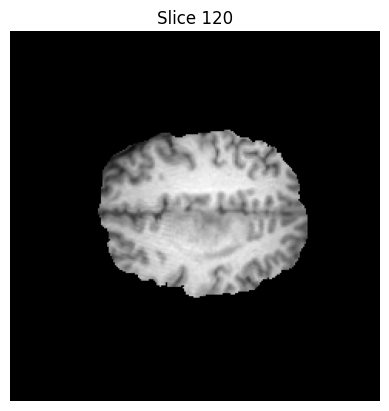

In [69]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def plot_nii(nii_path, slice_idx=None):
    """
    Plots a given slice of a single-channel NIfTI (.nii or .nii.gz) image.

    Args:
        nii_path (str): Path to the .nii or .nii.gz file.
        slice_idx (int, optional): Index of the slice to display. Defaults to the middle slice.
    """
    nii_img = nib.load(nii_path)
    img_data = nii_img.get_fdata()  # Convert to numpy array

    # Get slice index
    if slice_idx is None:
        slice_idx = img_data.shape[-1] // 2  # Use last axis for slicing

    # Plot the selected slice
    plt.imshow(img_data[:, :], cmap="gray")
    plt.axis("off")
    plt.title(f"Slice {slice_idx}")
    plt.show()


plot_nii("val-test/val/000077/BraTS20_Training_321_t1_107.nii")